# Preliminaries

The raw code may be hidden to draw attention to the results. Please use the button below if desired.

In [40]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Importing Libraries

We import the necessary packages and libraries for the analysis.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from pytrends.request import TrendReq
import pytrends
import statsmodels.api as sm
import os
from tqdm.notebook import tqdm
from fbprophet import Prophet
sns.set(font='DejaVu Sans')

In [4]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [5]:
%matplotlib inline

In [6]:
path = 'C:\\Users\\Dominique\\Documents\\Work\\ADB\\Nowcasting\\Data'
os.chdir(path)

## Importing Data

Here, we import the consolidated data.

In [ ]:
df = pd.read_stata('monthly_nc.dta')

df['wdate'] = pd.to_datetime(df.wdate)
df.set_index('wdate', inplace=True)
df.drop(columns=['mdate','month','year'], inplace=True)

In [8]:
# create sub-region variable
asean4 = ['IDN', 'PHL', 'SGP', 'THA']
cmlv = ['MMR', 'VNM']
east = ['CHN', 'JPN', 'KOR', 'TWN']
pac = ['AUS', 'NZL']

df['regions'] = 'ASEAN-4'
df.loc[df['country'].isin(cmlv), 'regions'] = 'CMLV'
df.loc[df['country'].isin(east), 'regions'] = 'East Asia'
df.loc[df['country'].isin(pac), 'regions'] = 'Pacific and Oceania'

In [9]:
iso = pd.read_excel(path + '\iso_codes.xlsx', header=0)
iso_dict = dict(zip(iso['Alpha-2 code'], iso['Alpha-3 code']))
df['country'].replace(iso_dict, inplace=True)

In [39]:
df.head()

country   pmi  credit    banking  hotels  cars  phones  travels  \
wdate                                                                        
2018-01-07     AUS  55.4    78.0  73.333333    78.0  65.0    86.5    78.25   
2018-01-14     AUS  55.4    82.0  64.000000    61.5  68.5    80.5    80.50   
2018-01-21     AUS  55.4    64.5  71.000000    75.5  64.5    83.0    72.00   
2018-01-28     AUS  55.4    67.5  72.666667    58.0  64.0    80.0    77.75   
2018-02-04     AUS  55.6    69.5  65.333333    61.5  64.5    72.5    77.75   

            restaurants  stbond  pe_ratio  regions  
wdate                                               
2018-01-07         77.0     NaN       NaN  ASEAN-4  
2018-01-14         75.5     NaN       NaN  ASEAN-4  
2018-01-21         81.0     NaN       NaN  ASEAN-4  
2018-01-28         86.0     NaN       NaN  ASEAN-4  
2018-02-04         71.0    1.94       NaN  ASEAN-4

## Defining Functions

Here, we define various helper functions to make the analysis less verbose.

In [ ]:
# dictionary of variables and labels
var_dict = {
    'pmi': 'Purchasing Managers Index',
    'credit': 'Credit Card - Search Index',
    'banking': 'Banking - Search Index',
    'cars': 'Automotives - Search Index',
    'phones': 'Mobile Phones - Search Index',
    'restaurants': 'Restaurants - Search Index',
    'stbond': 'Short-Term Bond Yield',
    'pe_ratio': 'P/E Ratio - Stock Index'
}

In [197]:
# set default size and style for all plots 
fig_dims = (6, 3)
dpi = 200
sns.set(style="white")

In [ ]:
# Plotting trends helper function
def plot_vars(region, reg_str): 
    """
    Helper function for plotting each variable, iteratively.
    """
    for var, label in var_dict.items():
        data = df[df.country.isin(region)]
        if data[var].isna().sum() != len(data):
            fig, ax = plt.subplots(figsize=fig_dims, dpi=dpi)
            palette = dict(zip(data.country.unique(), sns.color_palette('tab10')))

            sns.lineplot(data=data,
                         y=var,
                         x=data.index,
                         hue='country',
                         legend='brief',
                         palette=palette)
            plt.xticks(rotation=45)
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            plt.ylabel(label)
            plt.xlabel('')
            ax.set_title(reg_str + ': ' + label + ', 2017-2020')
        else:
            break

In [47]:
# Define a stationarity test

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def st_check(timeseries, country, variable, diff=False):  
    """
    Helper function for checking stationarity 
    """
    if diff==True:
        timeseries = df[df.country==country]
        timeseries = timeseries[variable].diff()
    else:
        timeseries = df[df.country==country]
        timeseries = timeseries[variable]
        
    rolmean = pd.Series(timeseries).rolling(window=12).mean() ## as month is year divide by 12
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std  = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation: {}'.format(country))
    plt.xticks(rotation=45)
    plt.show()
    
    #Perform Dickey-Fuller test
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    #Perform KPSS Test:
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries.dropna(), regression='ct')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [76]:
def plot_corr(df, country, tr_start, tr_end, te_start, te_end, diff=False):
    """
    Correlogram plotter
    """
    df = df[df.country == country]
    tra = df['pmi'][tr_start:tr_end].dropna()
    tes = df['pmi'][te_start:te_end].dropna()
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    if diff==True:
        fig = sm.graphics.tsa.plot_acf(tra.diff().dropna(), lags=20, ax=ax[0])
        fig = sm.graphics.tsa.plot_pacf(tra.diff().dropna(), lags=20, ax=ax[1])
    else:
        fig = sm.graphics.tsa.plot_acf(tra.dropna(), lags=20, ax=ax[0])
        fig = sm.graphics.tsa.plot_pacf(tra.dropna(), lags=20, ax=ax[1])
    plt.suptitle('ACF and PACF: {}'.format(country))
    plt.show()

In [227]:
def fit_arima(country, tr_start, tr_end, te_start, te_end, order):
    buf = df[df.country == country]

    tra = buf['pmi'][tr_start:tr_end].dropna()
    tes = buf['pmi'][te_start:te_end].dropna()

    arima = sm.tsa.statespace.SARIMAX(tra,order=order,
                                    enforce_stationarity=False, 
                                    enforce_invertibility=False).fit()
    print(arima.summary())

    res = arima.resid
    fig,ax = plt.subplots(2,1,figsize=(15,8))
    fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
    fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
    plt.title('Correlograms for country: {}'.format(country))
    plt.show()

    pred = arima.predict(80,90)[1:]
    print('ARIMA model MSE for 10-step ahead forecast:{}'.format(mean_squared_error(tra[-10:],pred)))

    pd.DataFrame({'test':tra[-10:].values,'pred':pred.values}).plot();
    plt.title('10-Step Ahead ARIMA Forecast for {}'.format(country))
    plt.show()

In [ ]:
def fit_arimax(country, tr_start, tr_end, te_start, te_end, order):
    buf = df[df.country == country]

    tra = buf['pmi'][tr_start:tr_end].dropna()
    tes = buf['pmi'][te_start:te_end].dropna()

    arima = sm.tsa.statespace.SARIMAX(tra,
                                      order=order,
                                    enforce_stationarity=False, 
                                    enforce_invertibility=False).fit()
    print(arima.summary())

    res = arima.resid
    fig,ax = plt.subplots(2,1,figsize=(15,8))
    fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
    fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
    plt.title('Correlograms for country: {}'.format(country))
    plt.show()

    pred = arima.predict(80,90)[1:]
    print('ARIMA model MSE for 10-step ahead forecast:{}'.format(mean_squared_error(tra[-10:],pred)))

    pd.DataFrame({'test':tra[-10:].values,'pred':pred.values}).plot();
    plt.title('10-Step Ahead ARIMA Forecast for {}'.format(country))
    plt.show()

## Summary Statistics

Basic summary statistics

In [17]:
df.describe()

pmi       credit      banking       hotels         cars  \
count  1592.000000  1592.000000  1592.000000  1592.000000  1592.000000   
mean     50.183982    55.287060    49.976340    34.676822    62.348304   
std       4.616832    16.840152    14.389989    18.764133    12.852011   
min      27.400000    13.000000    11.666667     0.000000    11.000000   
25%      48.900000    43.500000    39.666667    21.000000    55.500000   
50%      51.300000    56.000000    50.666667    34.250000    63.500000   
75%      52.700000    67.000000    60.333333    48.500000    71.000000   
max      59.700000    98.500000    91.666667    88.500000    97.000000   

            phones      travels  restaurants  
count  1592.000000  1592.000000  1592.000000  
mean     59.676822    59.801351    54.893844  
std      13.627692    15.252973    17.889063  
min      14.000000    15.000000     6.000000  
25%      50.500000    52.187500    44.000000  
50%      60.000000    63.000000    57.000000  
75%      69.500000    70.750000    67.500000  
max     100.000000    91.250000    99.500000

Observations per country

In [17]:
df.groupby('country').count()

pmi  credit  banking  hotels  cars  phones  travels  restaurants  \
country                                                                     
AUS      125     125      125     125   125     125      125          125   
CHN      125     125      125     125   125     125      125          125   
IDN      123     123      123     123   123     123      123          123   
IND      119     119      119     119   119     119      119          119   
JPN      122     122      122     122   122     122      122          122   
KOR      111     111      111     111   111     111      111          111   
MMR      122     122      122     122   122     122      122          122   
MYS      116     116      116     116   116     116      116          116   
NZL      111     111      111     111   111     111      111          111   
PHL      102     102      102     102   102     102      102          102   
SGP      113     113      113     113   113     113      113          113   
THA       90      90       90      90    90      90       90           90   
TWN      114     114      114     114   114     114      114          114   
VNM       99      99       99      99    99      99       99           99   

         stbond  pe_ratio  regions  
country                             
AUS          71         0      125  
CHN           0        91      125  
IDN          46         0      123  
IND           0       110      119  
JPN          65         0      122  
KOR          40        83      111  
MMR           0         0      122  
MYS          45         0      116  
NZL          48         0      111  
PHL           0         0      102  
SGP           0         0      113  
THA          46        68       90  
TWN          45         0      114  
VNM           0         0       99

Mean values per country

In [18]:
df.groupby('country').mean()

pmi     credit    banking     hotels  \
country                                                                  
Australia                   51.788800  69.204000  65.984000  46.080000   
China                       49.972000  43.456000  36.322667  15.528000   
India                       50.746218  58.016807  63.994398  51.852941   
Indonesia                   50.720325  65.869919  63.560976  35.044715   
Japan                       49.492623  40.442623  53.183060  39.598361   
Korea (the Republic of)     49.405405  49.536036  46.162162  36.702703   
Malaysia                    48.102586  60.318966  52.054598  38.767241   
Myanmar                     50.101639  40.782787  35.265027  13.463115   
New Zealand                 50.227928  58.594595  43.930931  34.923423   
Philippines (the)           50.071569  66.926471  31.856209  38.867647   
Singapore                   50.334513  76.008850  55.678466  41.712389   
Taiwan (Province of China)  51.700877  41.964912  48.932749  35.635965   
Thailand                    49.721111  62.716667  46.940741  29.494444   
Viet Nam                    49.917172  42.176768  52.195286  27.348485   

                                 cars     phones    travels  restaurants  
country                                                                   
Australia                   69.256000  76.596000  69.012000    71.044000  
China                       54.236000  45.124000  45.966000    41.924000  
India                       62.470588  60.521008  65.552521    48.932773  
Indonesia                   65.621951  65.235772  60.308943    43.894309  
Japan                       63.844262  56.840164  57.831967    67.627049  
Korea (the Republic of)     62.648649  50.031532  64.540541    54.396396  
Malaysia                    72.715517  66.456897  68.107759    56.159483  
Myanmar                     48.807377  45.872951  47.747951    35.754098  
New Zealand                 54.608108  65.788288  54.033784    58.234234  
Philippines (the)           61.607843  62.308824  61.046569    54.343137  
Singapore                   63.411504  63.584071  57.473451    65.190265  
Taiwan (Province of China)  64.960526  54.254386  65.936404    65.201754  
Thailand                    72.522222  63.622222  64.652778    52.483333  
Viet Nam                    57.984848  60.777778  56.696970    54.070707

# Visualization

### Distributions

Here we visually examine the variables with a Seaborn pairplot showing the distributions of each variable, by sub-region. We see that CMLV tends to veer towards the lower end of the distribution, whereas the opposite is true for Pacific and Oceania and for East Asia.

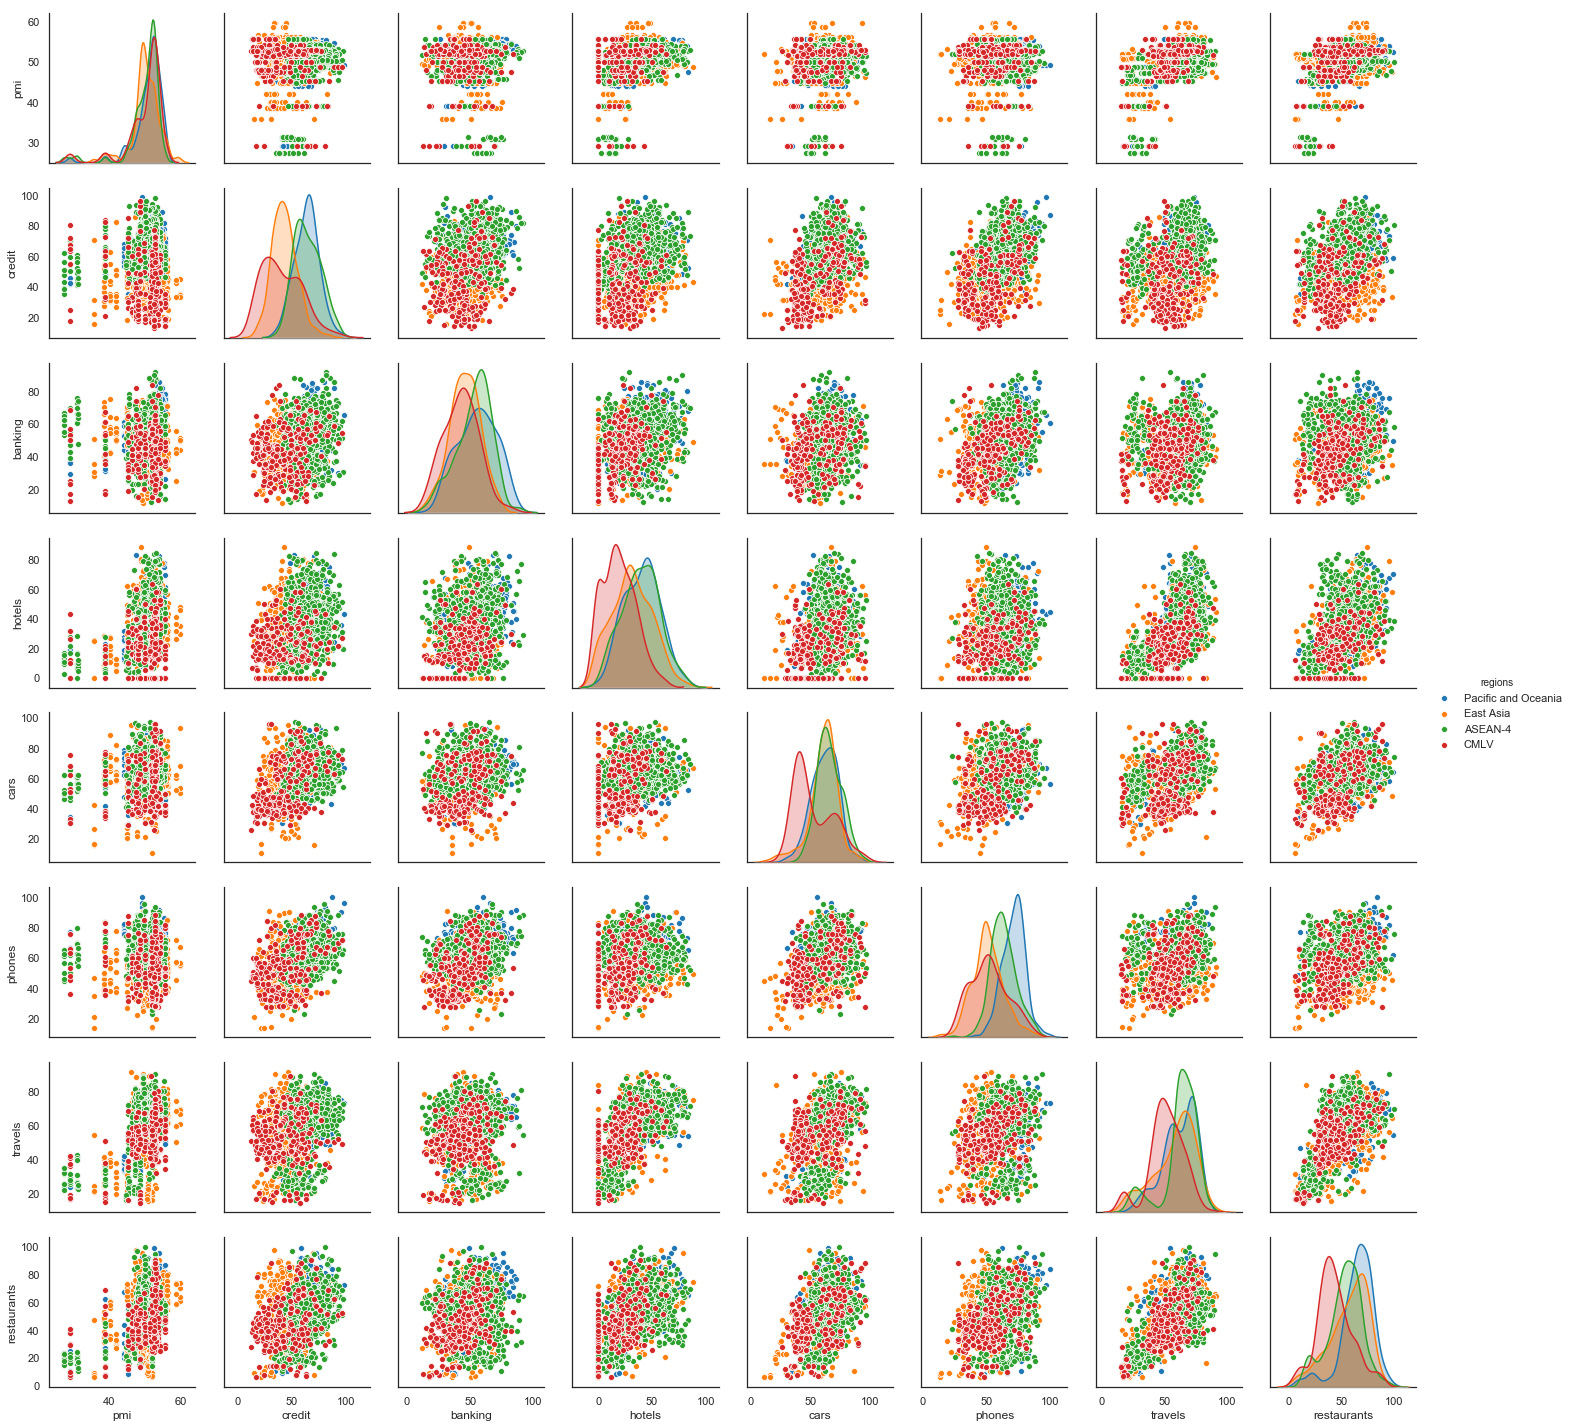

In [230]:
import warnings
warnings.filterwarnings("ignore")
sns.pairplot(data=df, vars=['pmi', 'credit', 'banking', 'hotels', 'cars', 'phones', 'travels',
       'restaurants'], hue='regions', palette='tab10');

### Basic Trends
This section illustrates the basic behavior of the various variables we have in the dataset, separated by sub-region and country. 

In [141]:
globals()['region'] = [asean4, cmlv, east, pac]
regions = ['ASEAN-4', 'CMLV', 'East Asia', 'Pacific and Oceania']

#### ASEAN-4 Countries

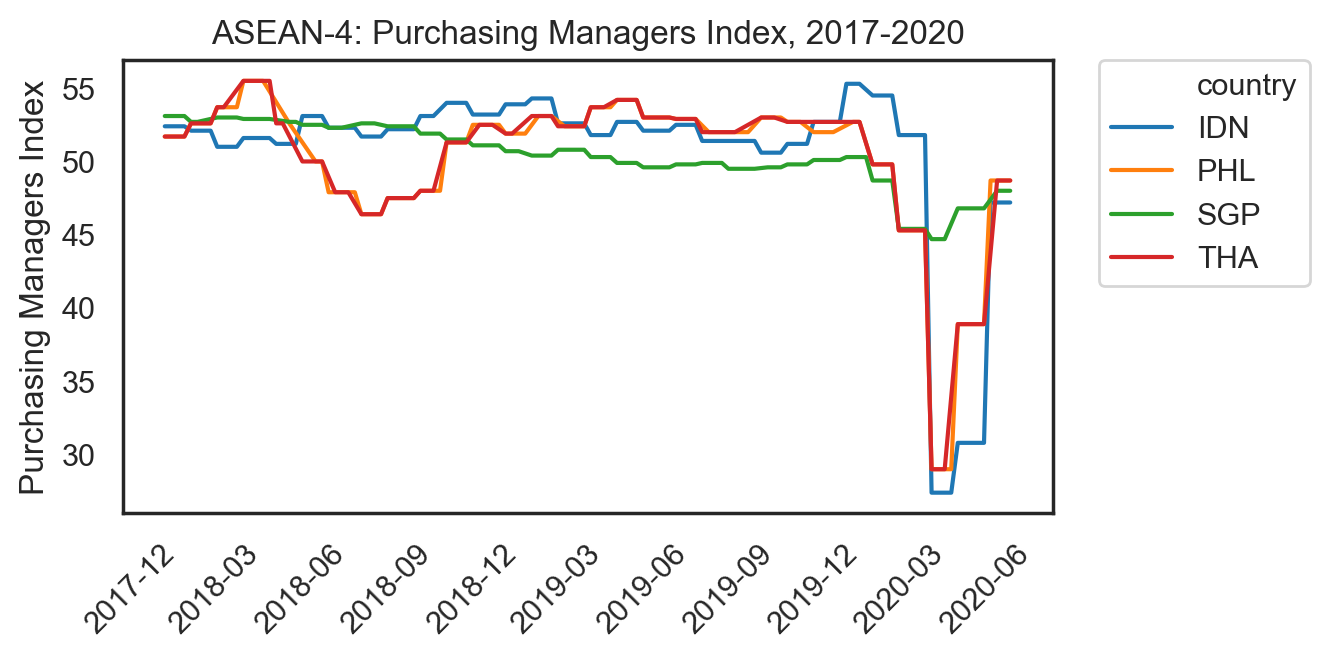

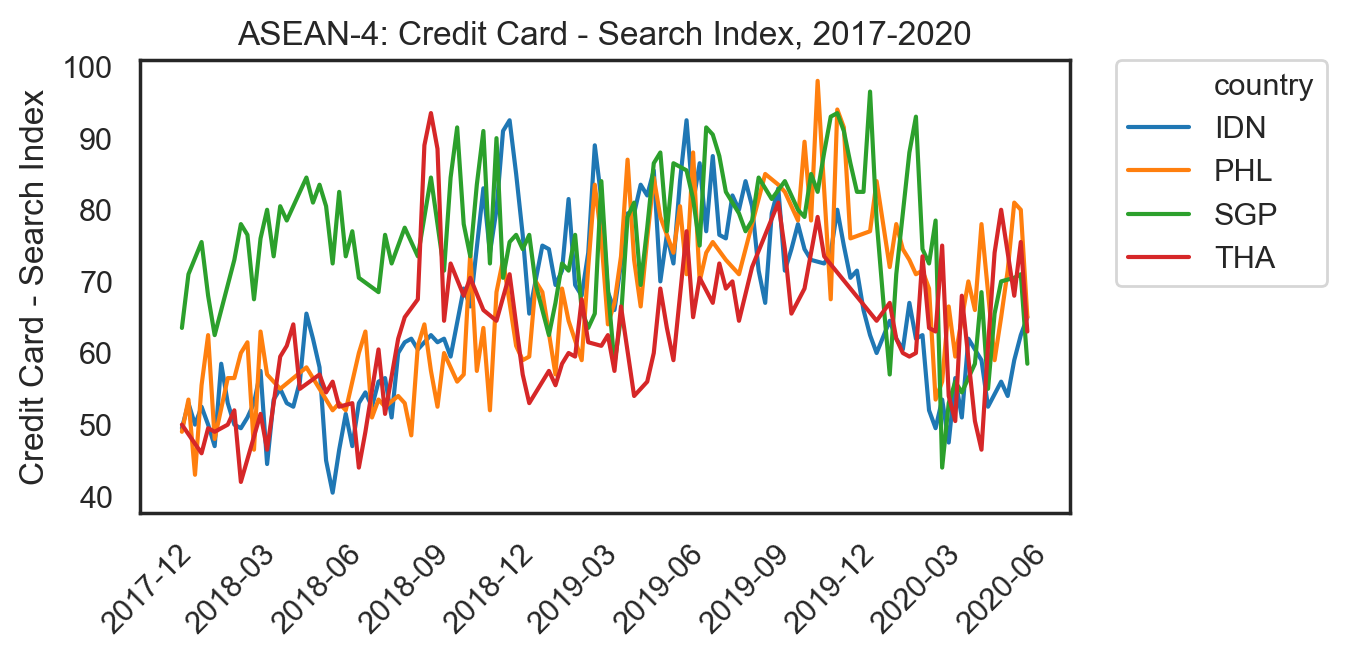

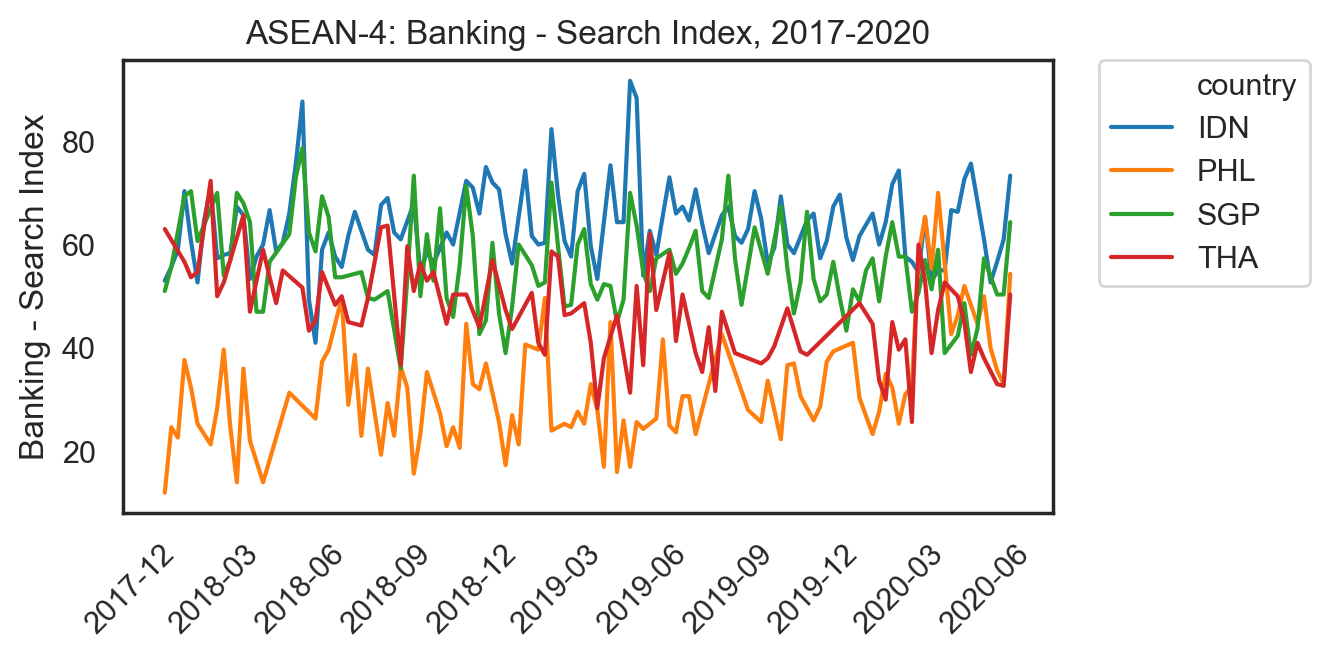

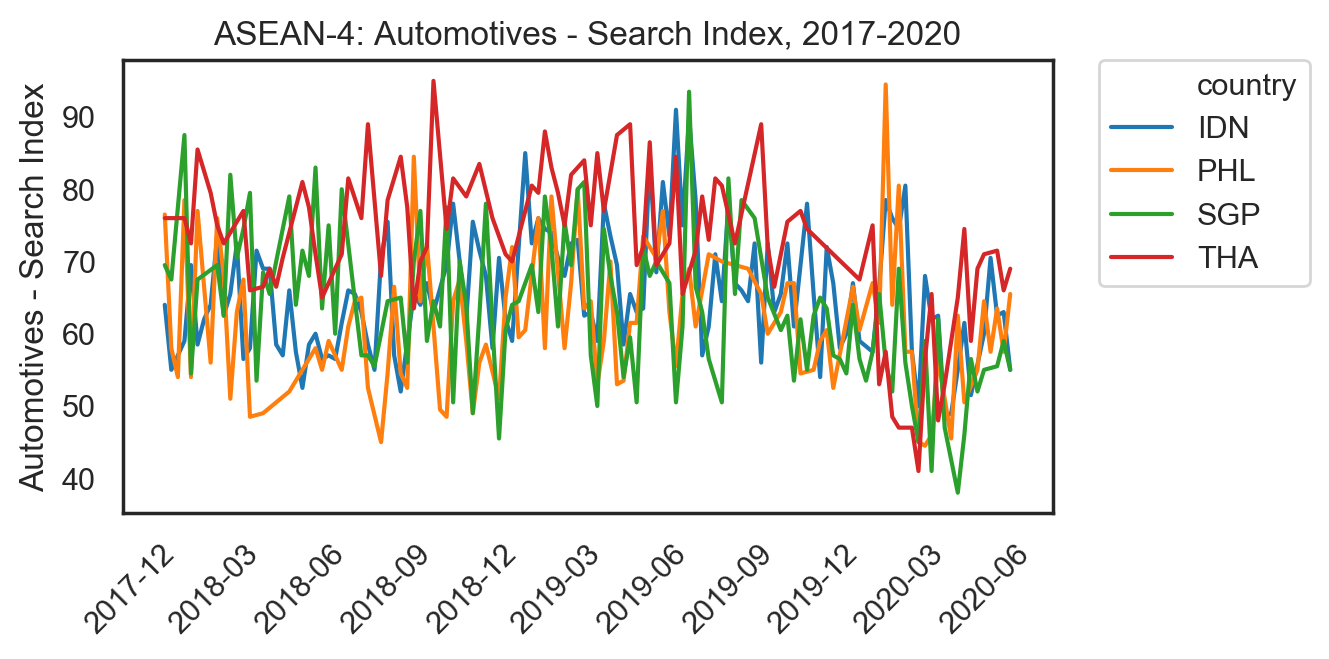

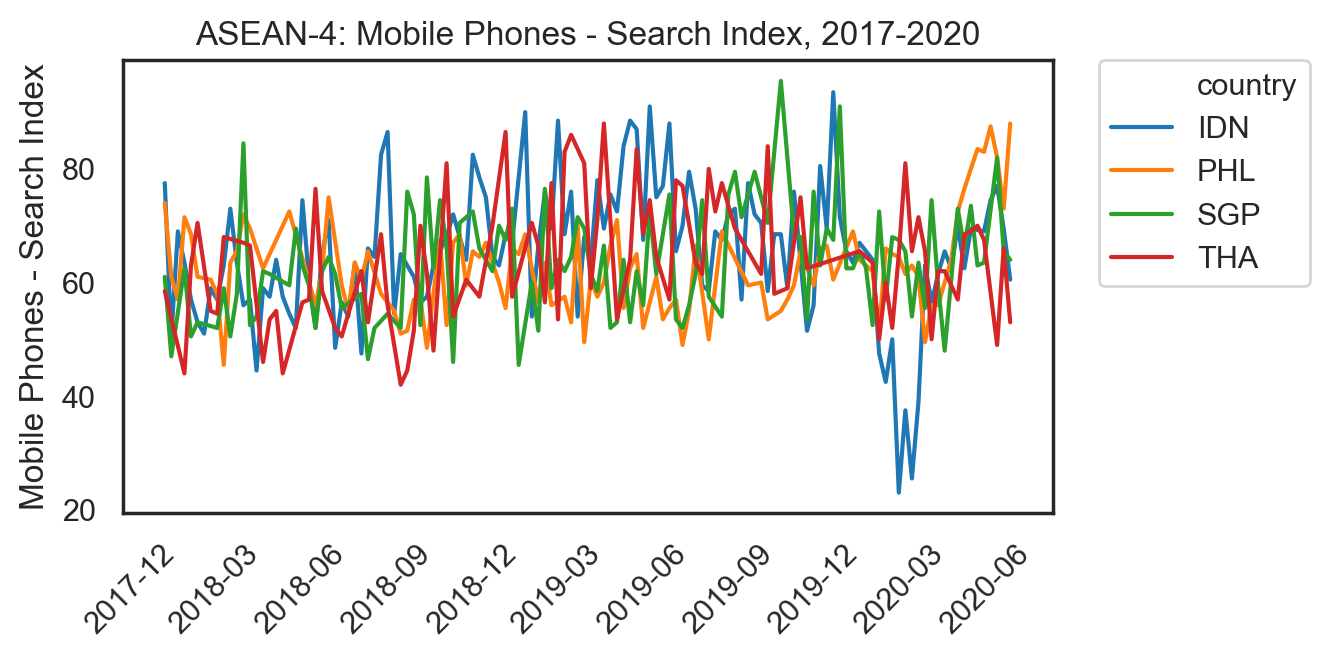

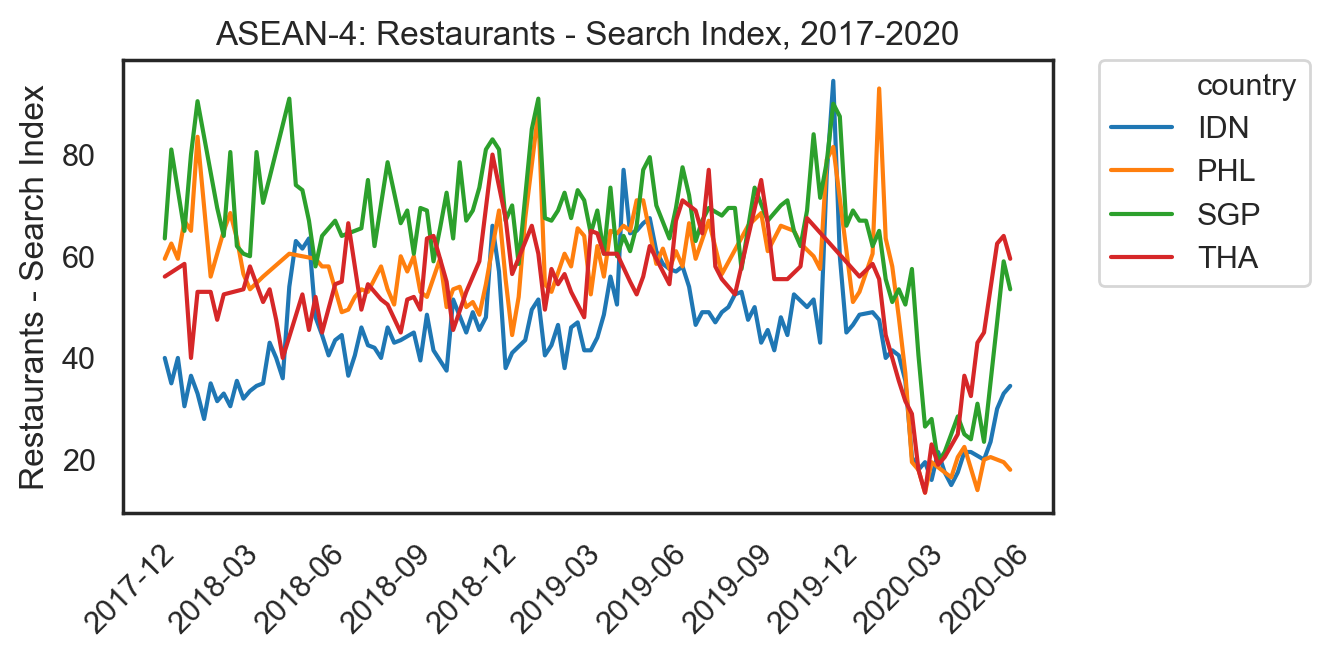

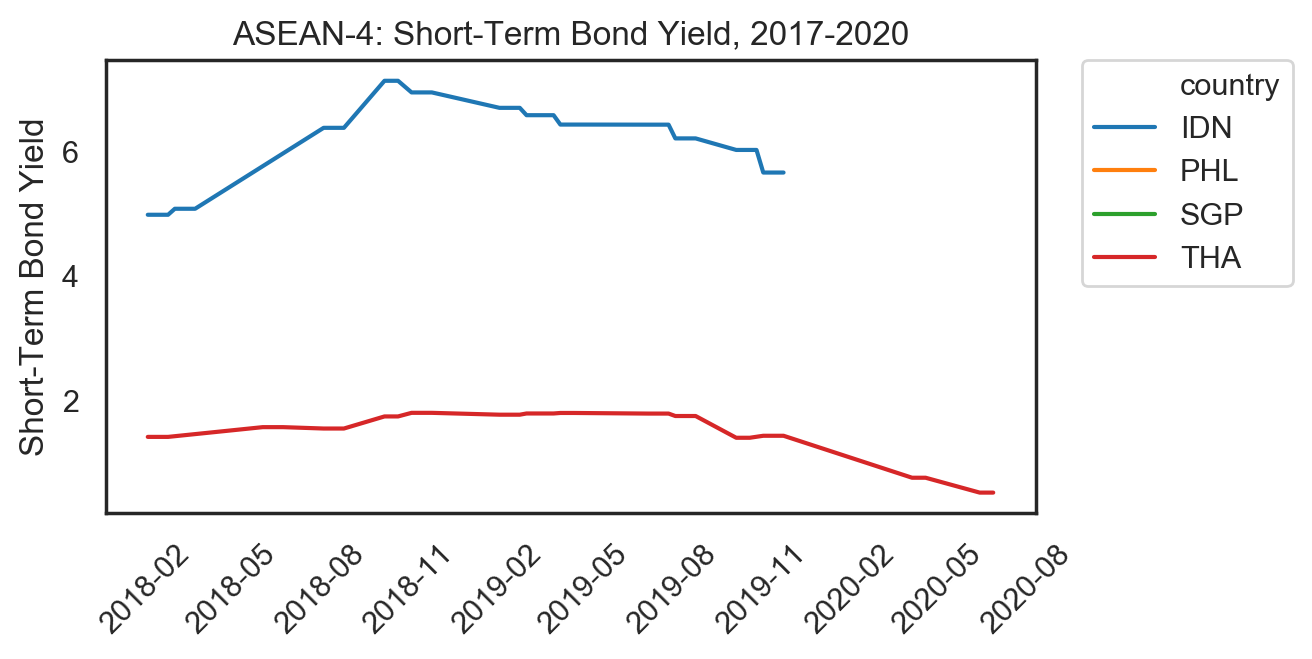

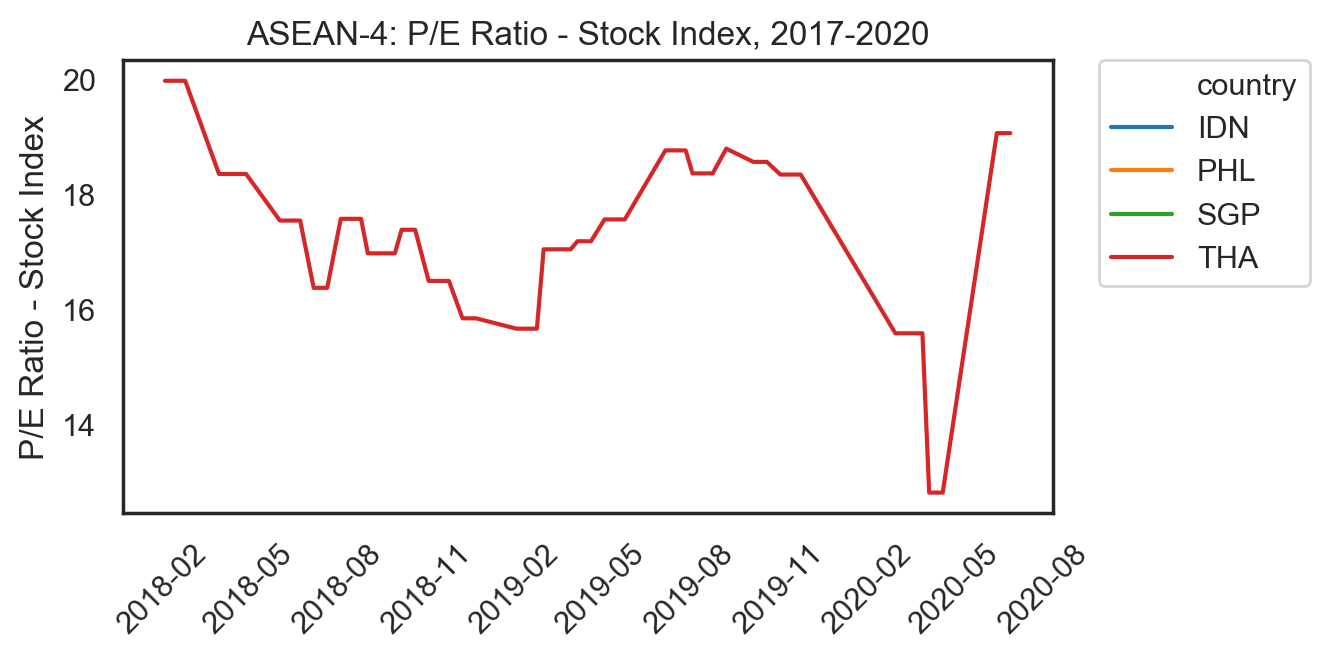

In [165]:
region = asean4
reg_str = "ASEAN-4"
plot_vars(region, reg_str)

#### CMLV

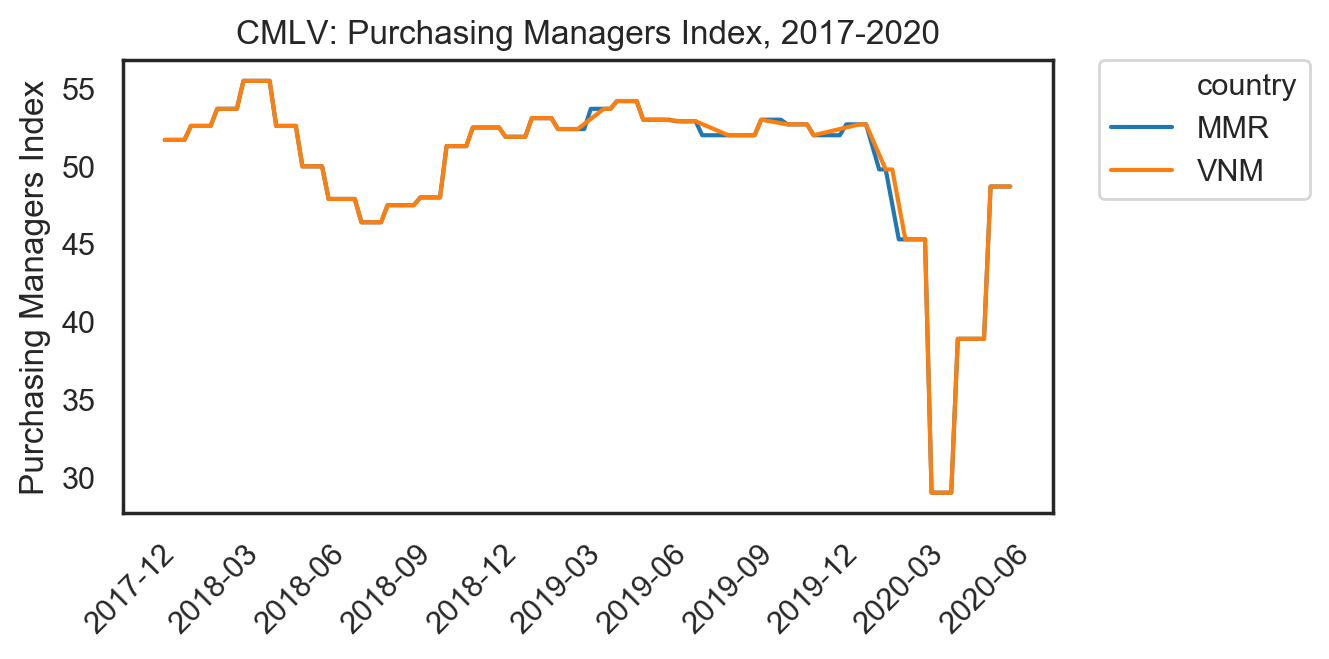

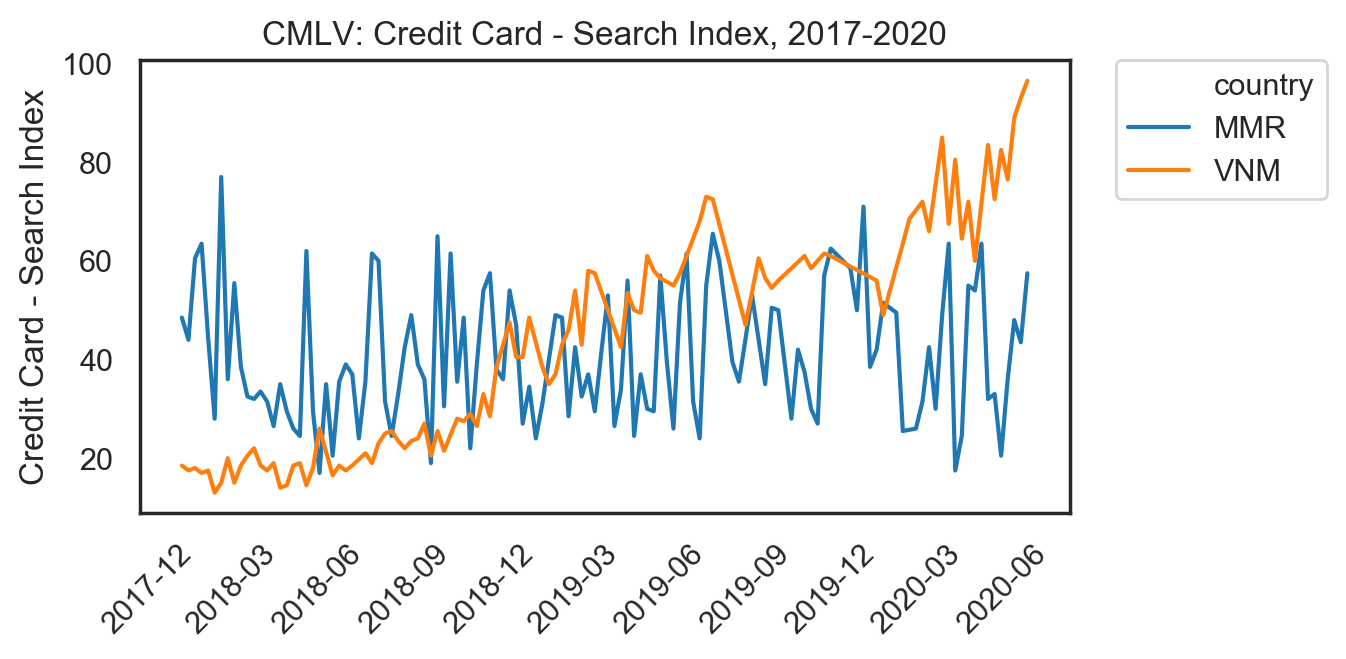

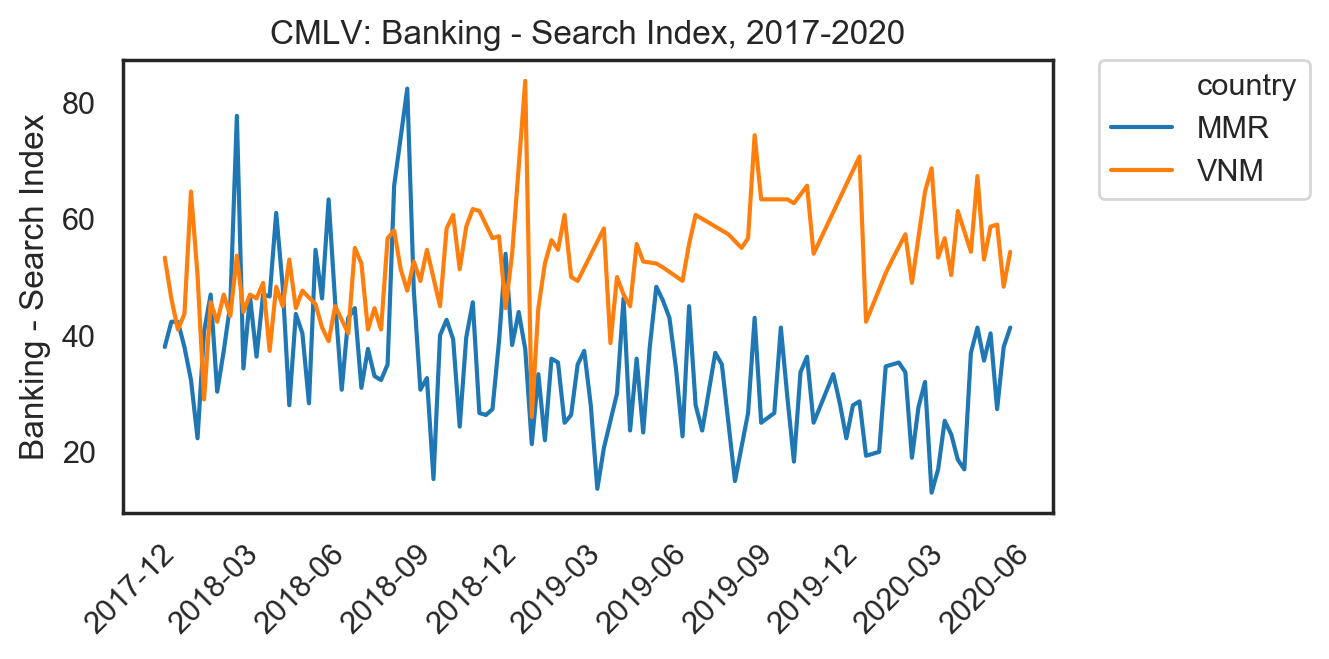

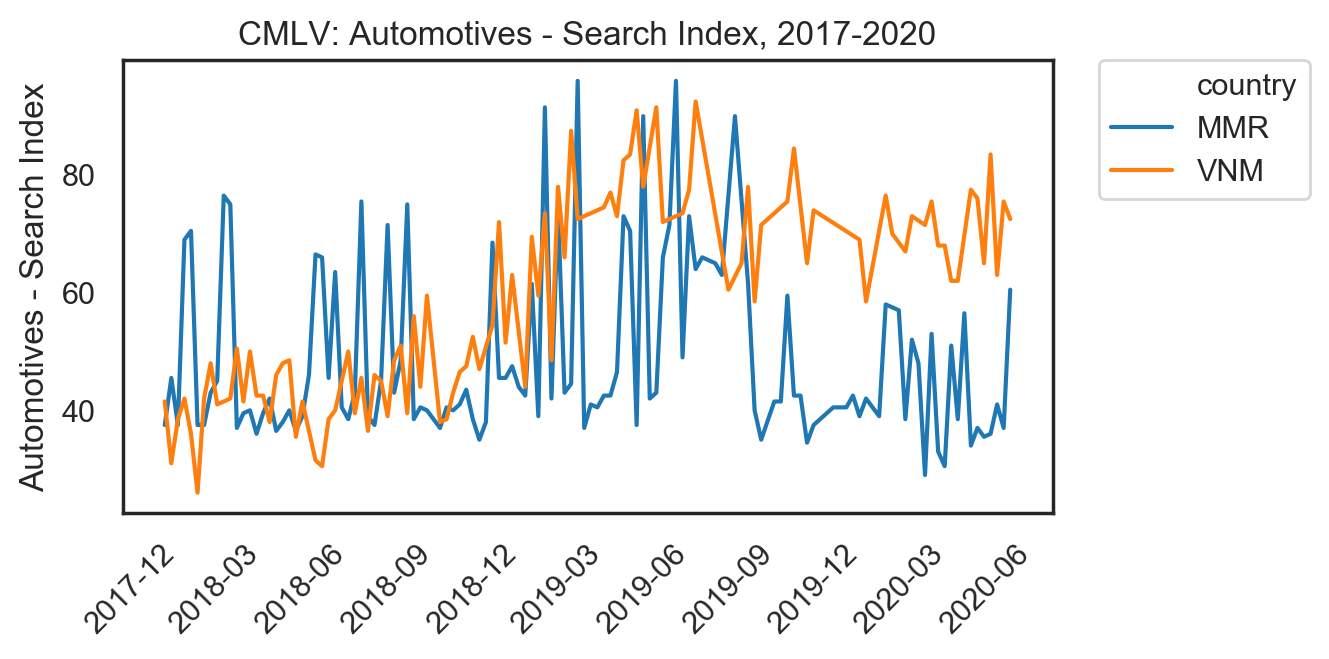

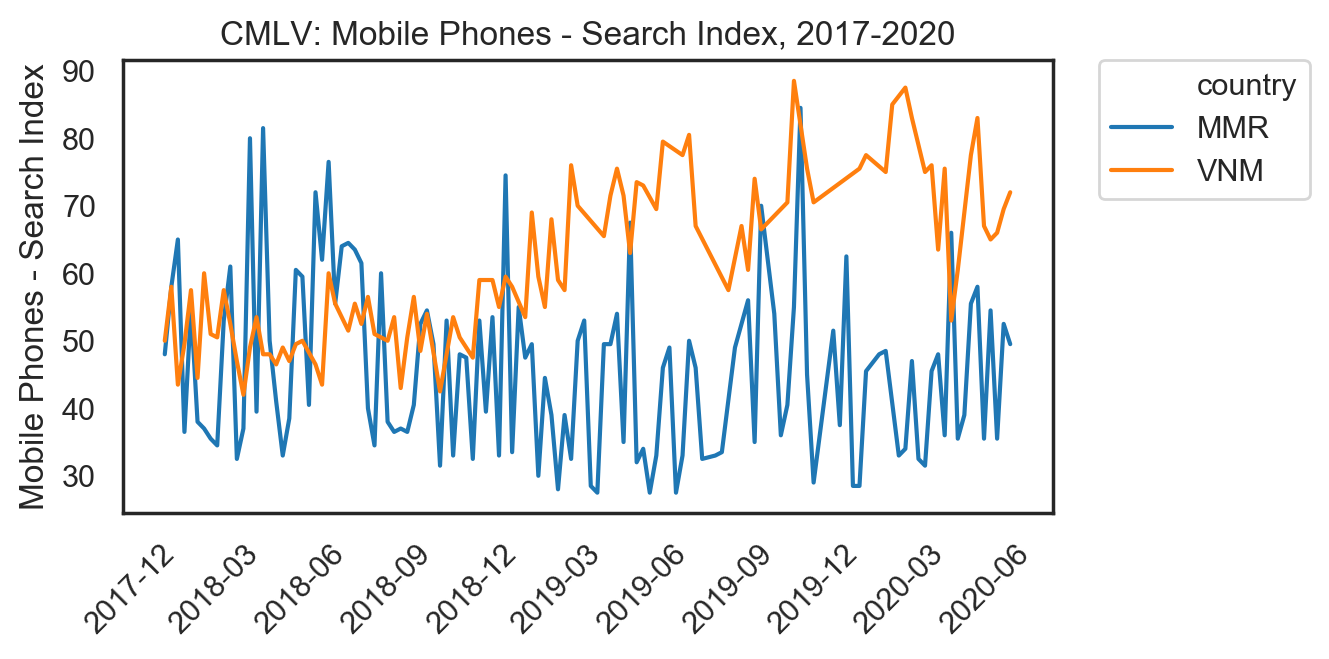

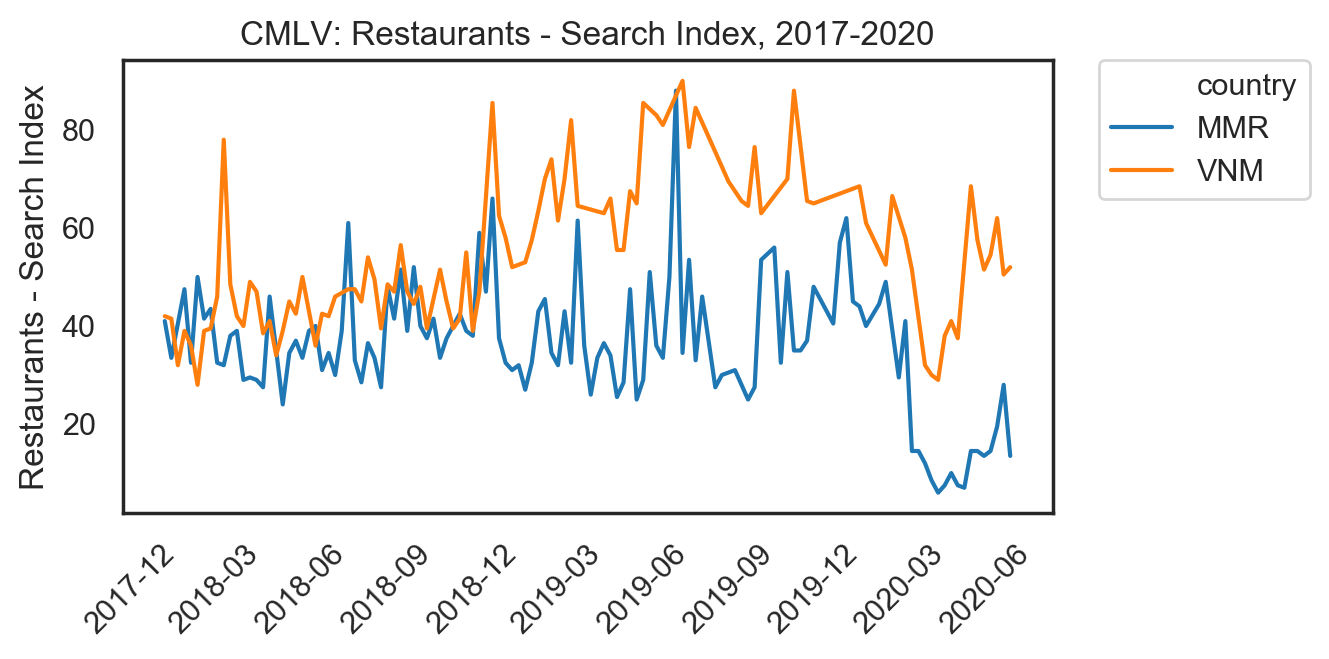

In [198]:
region = cmlv
reg_str = "CMLV"
plot_vars(region, reg_str)

#### East Asia

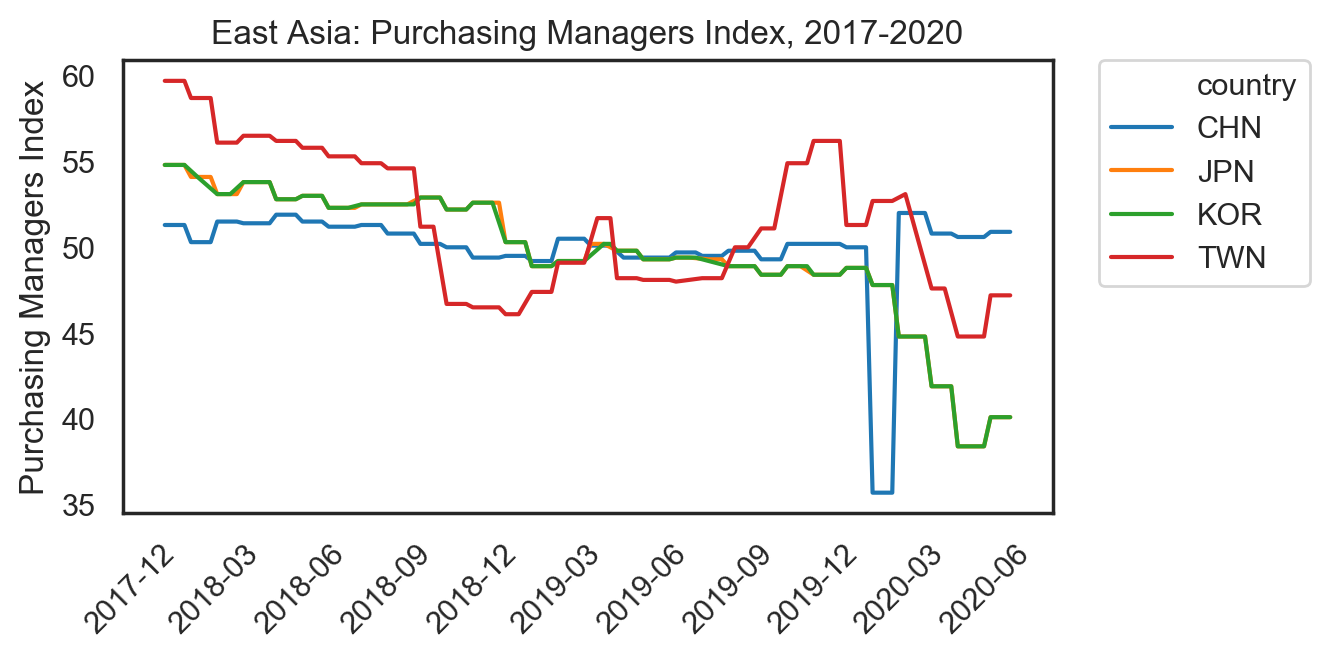

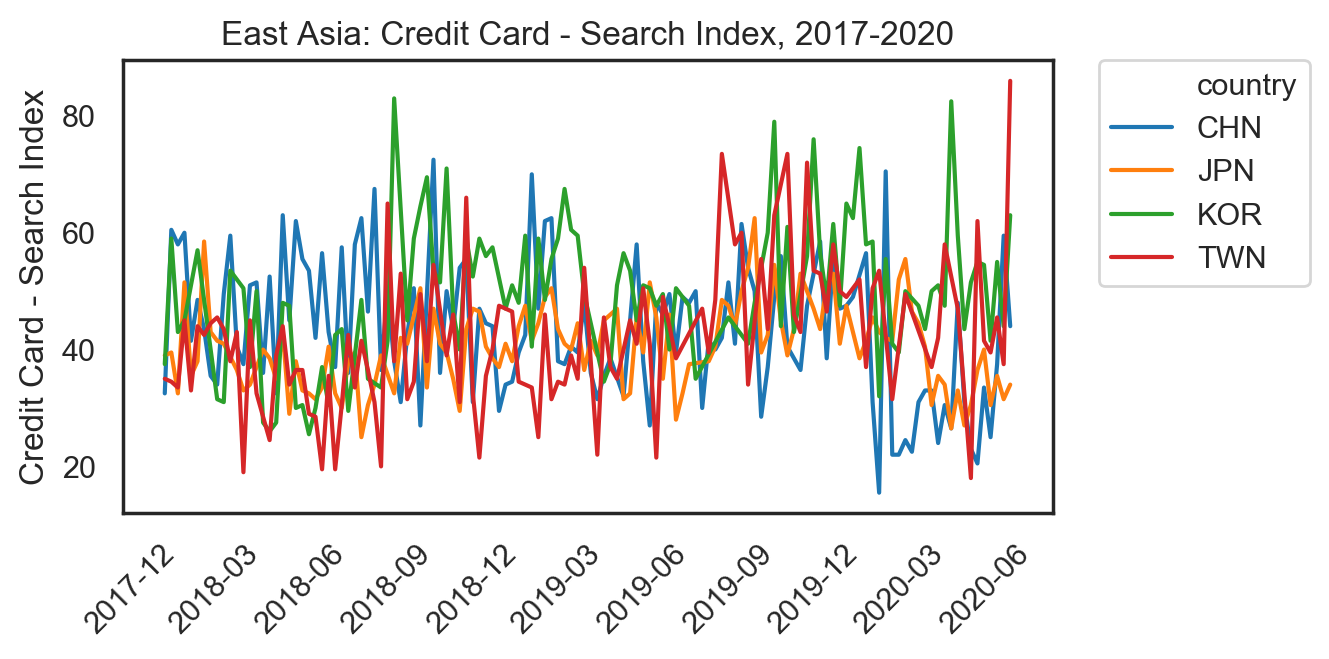

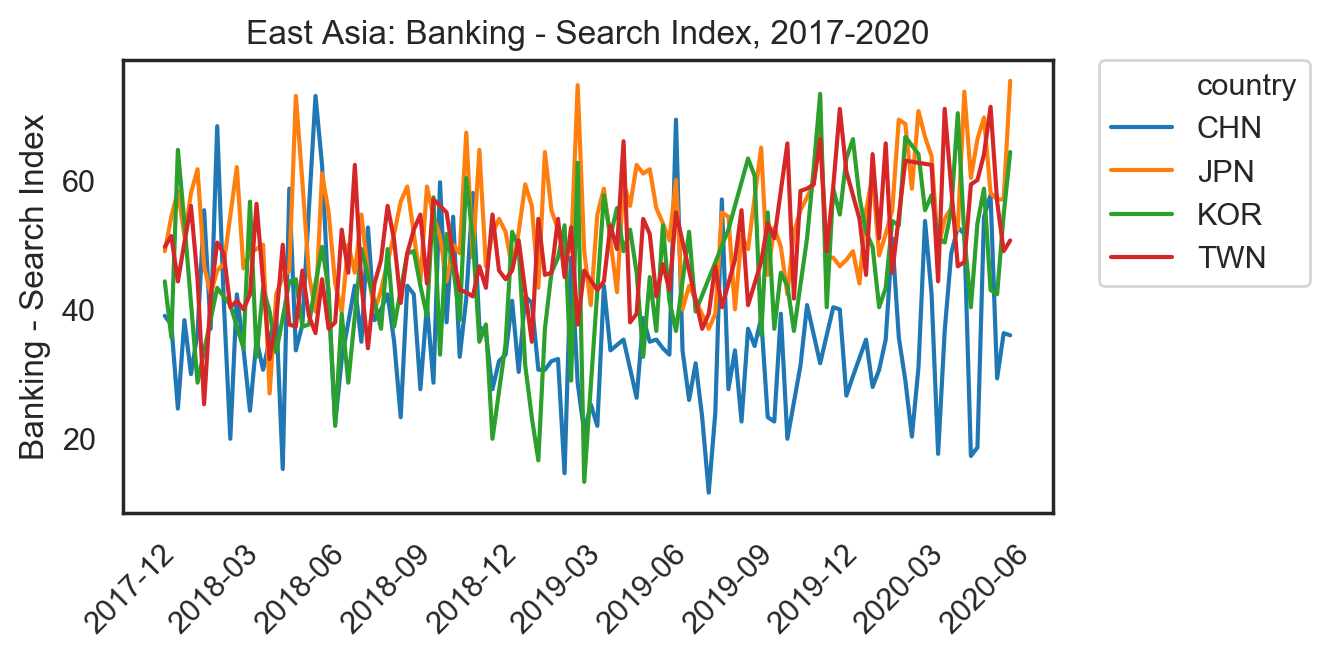

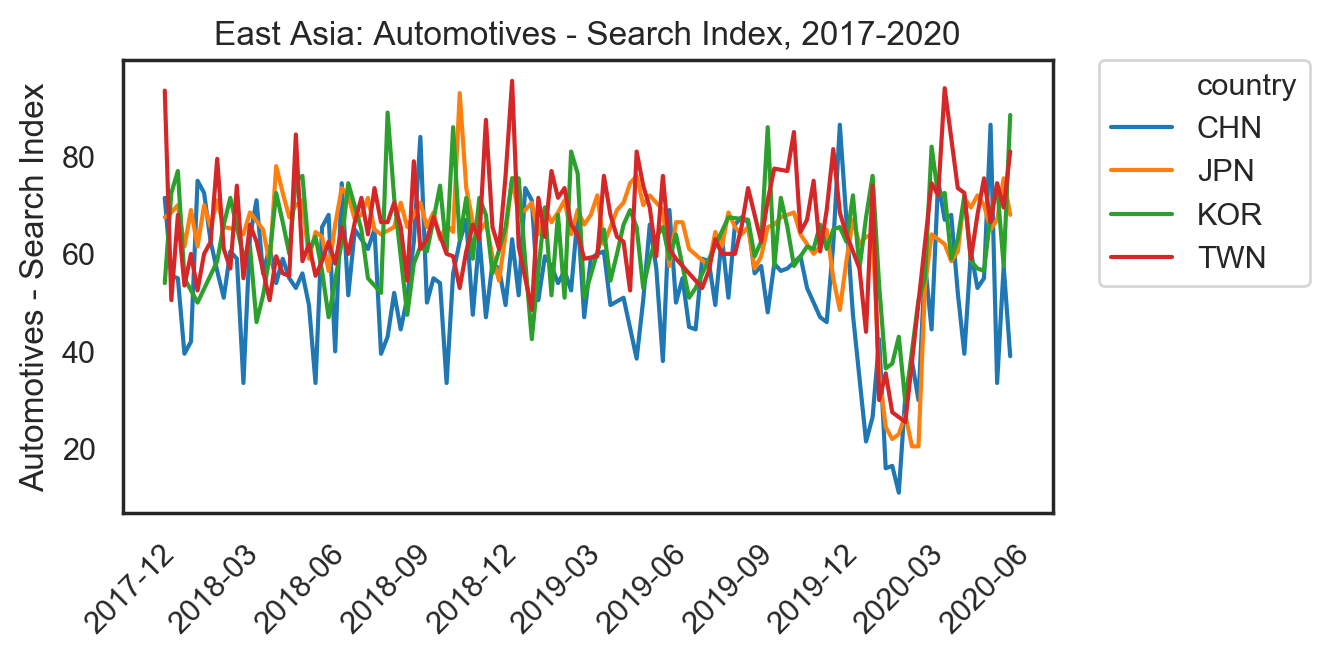

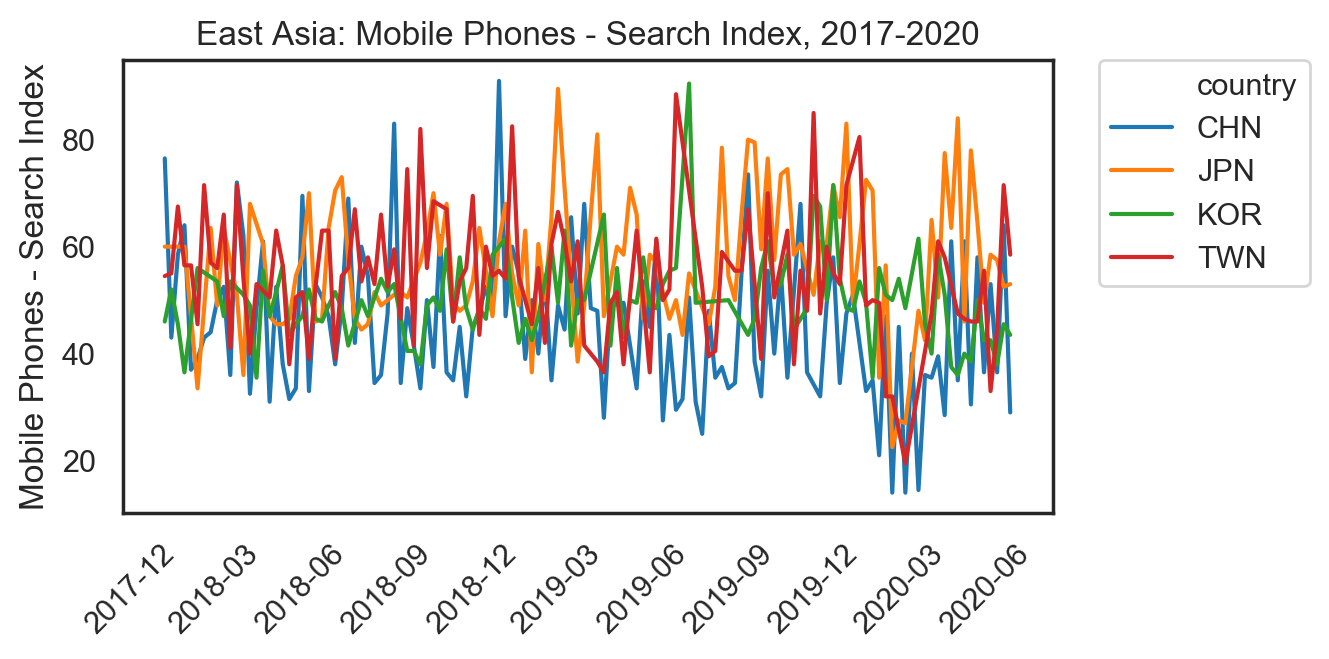

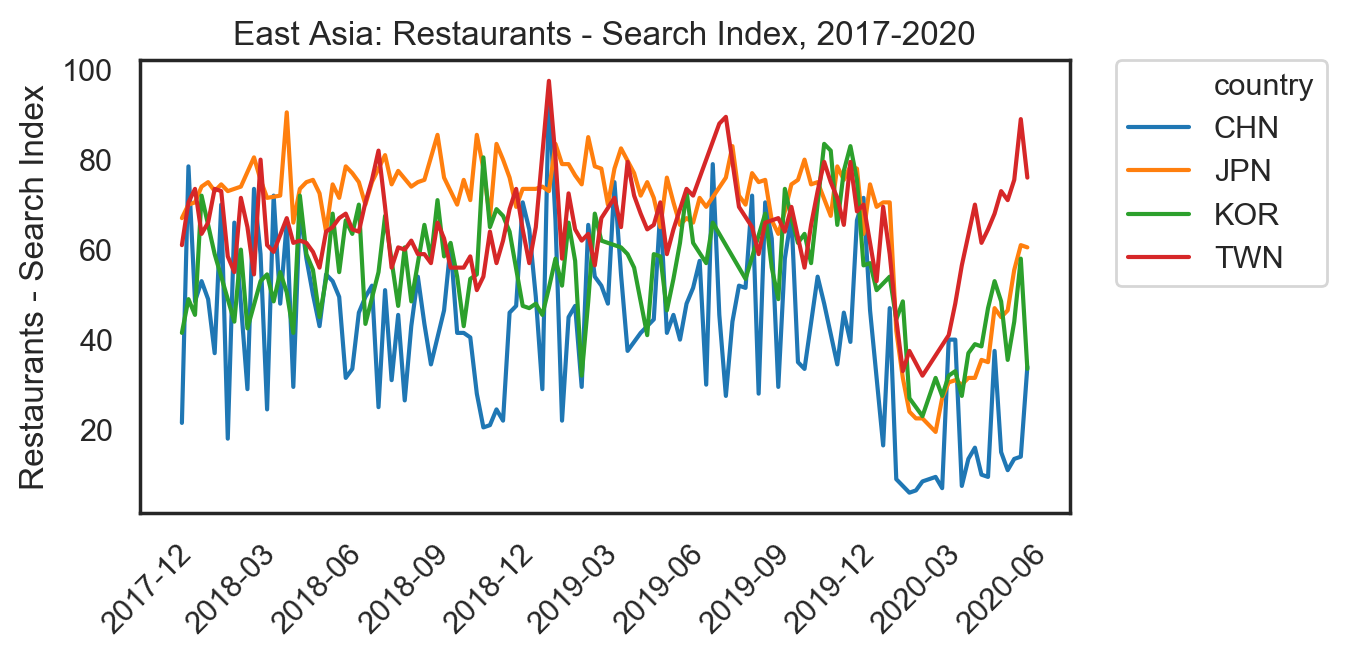

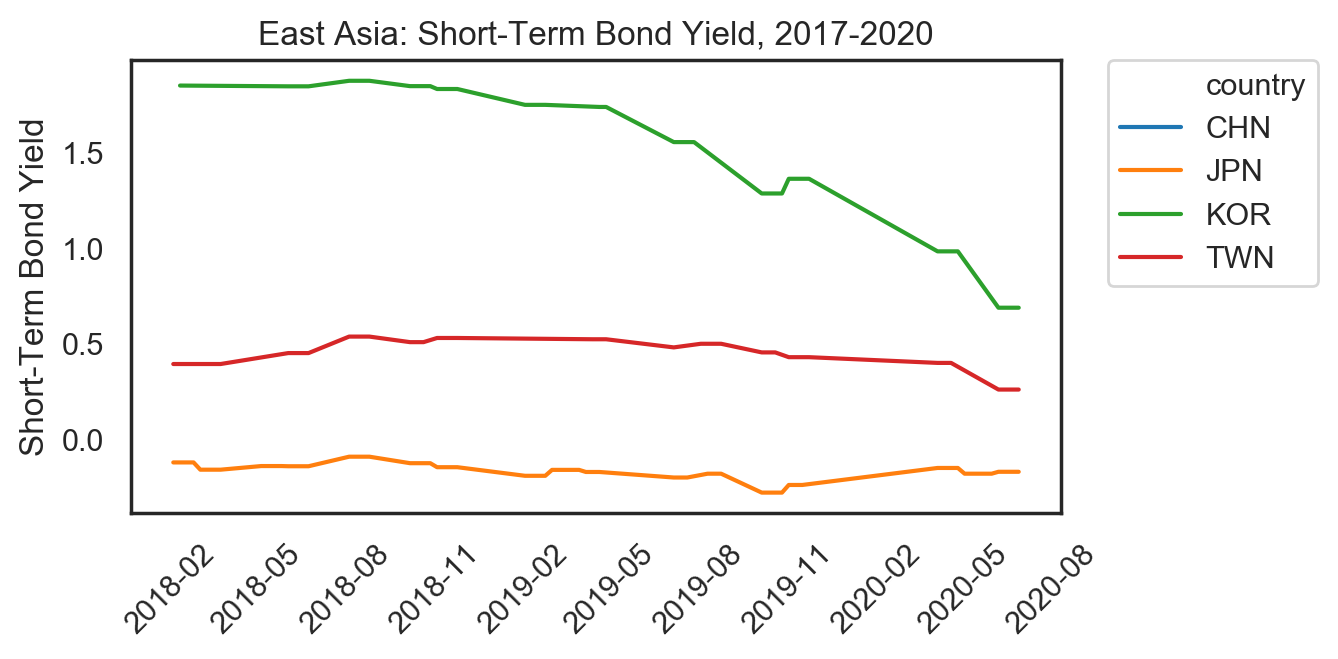

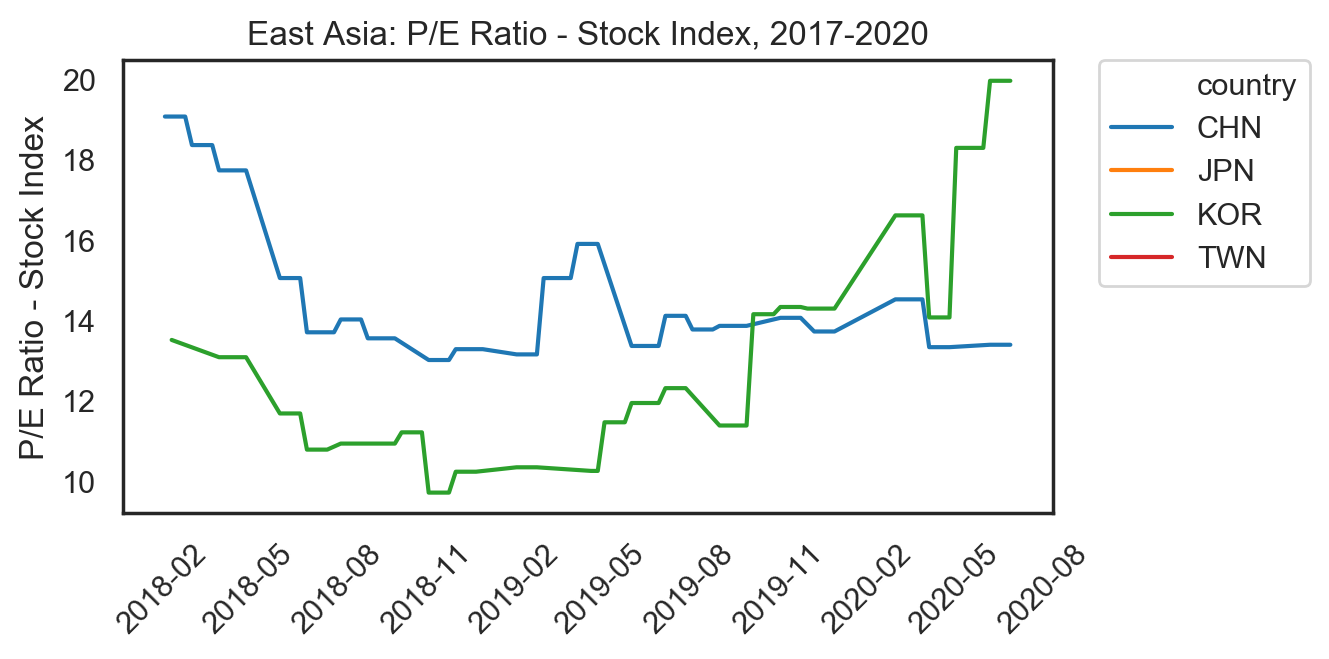

In [191]:
region = east
reg_str = "East Asia"
plot_vars(region, reg_str)

#### Pacific and Oceania

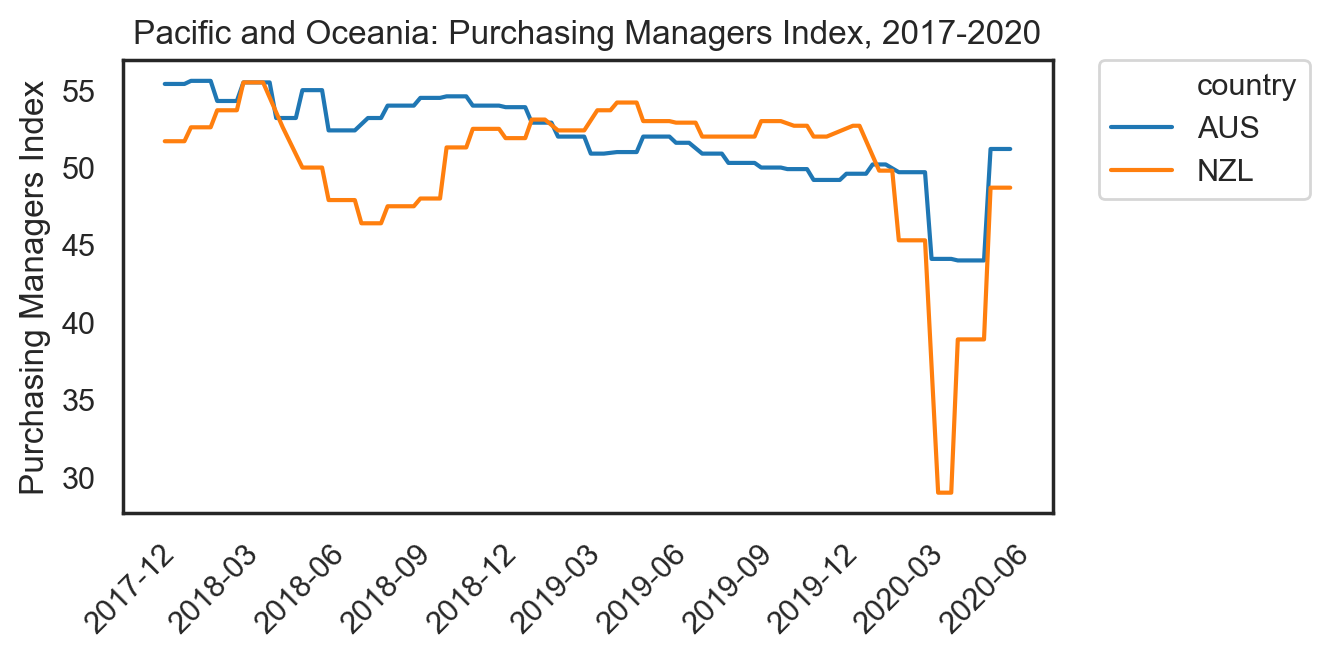

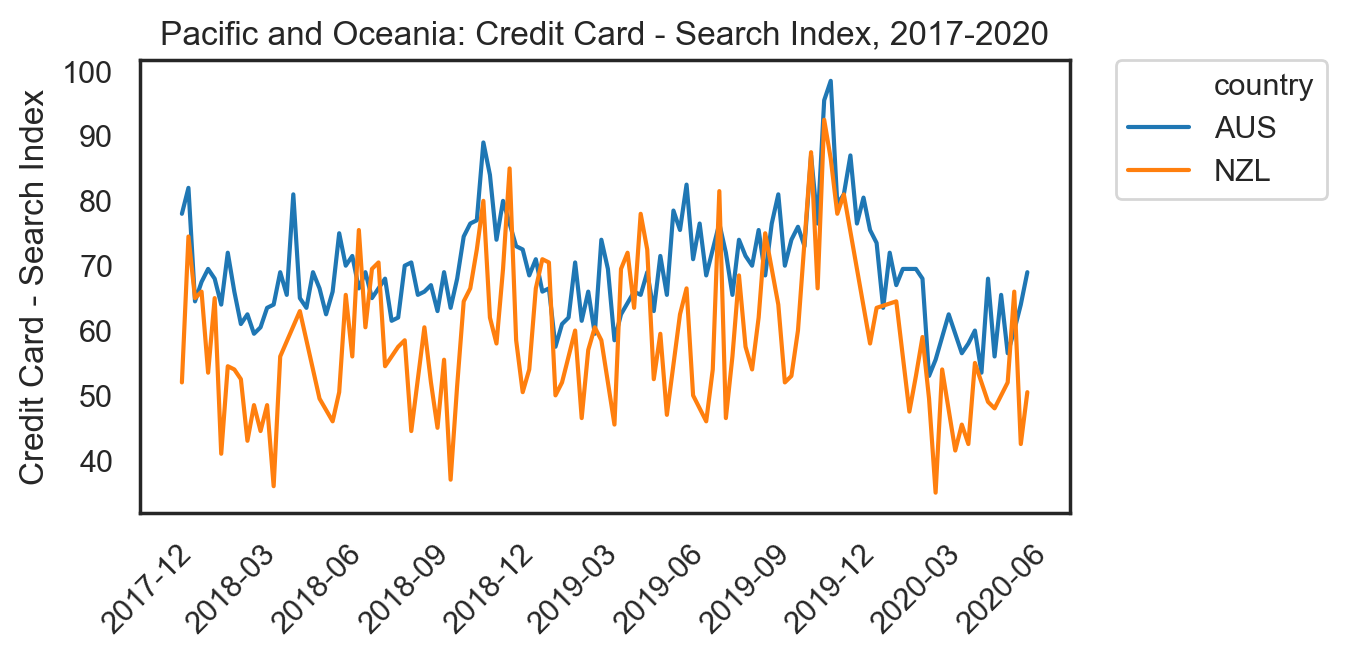

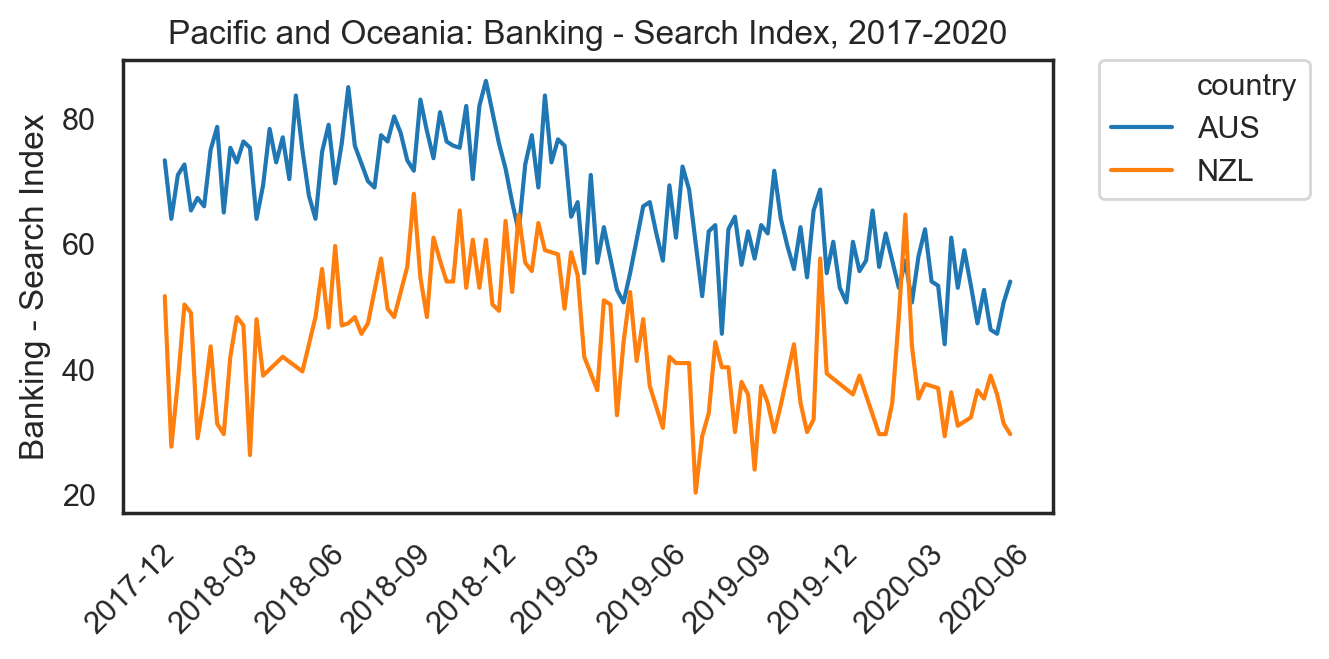

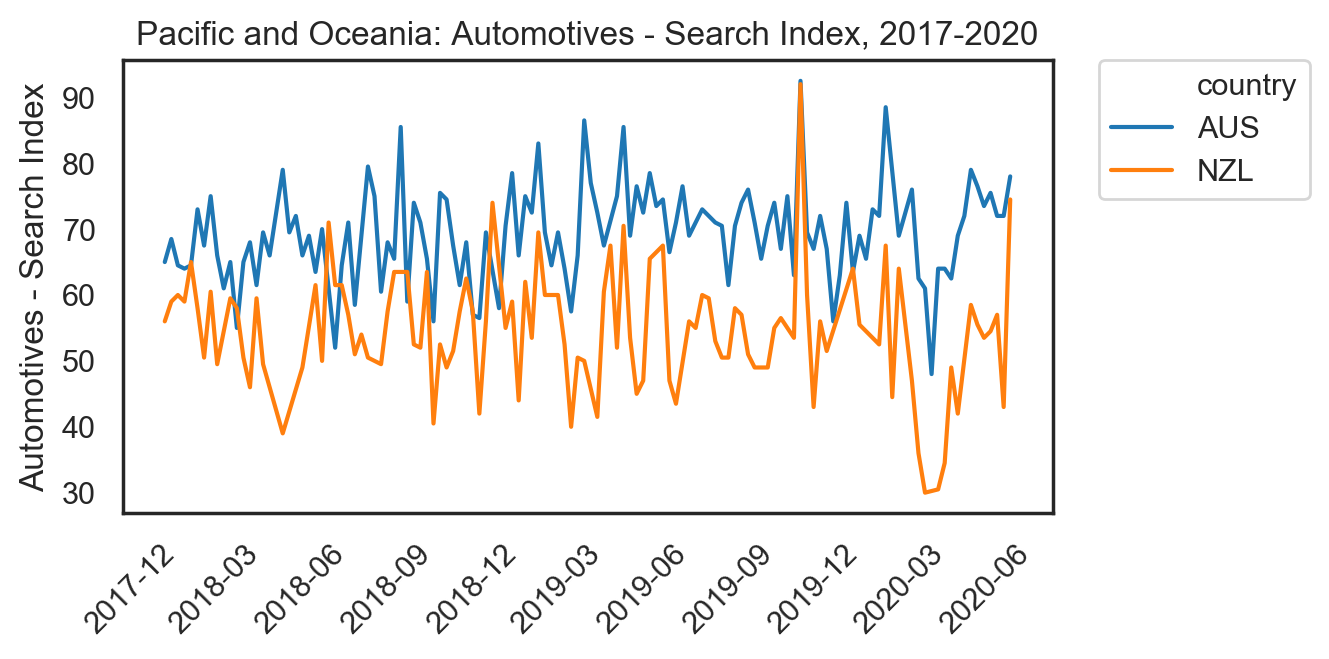

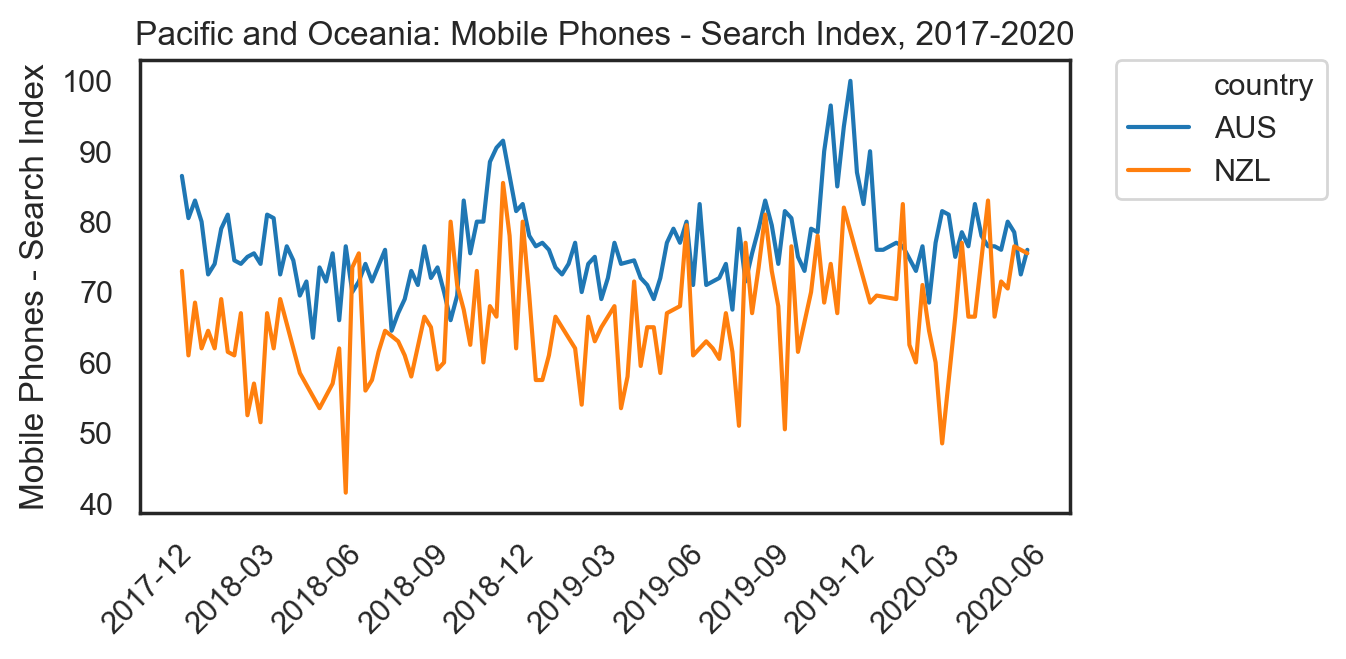

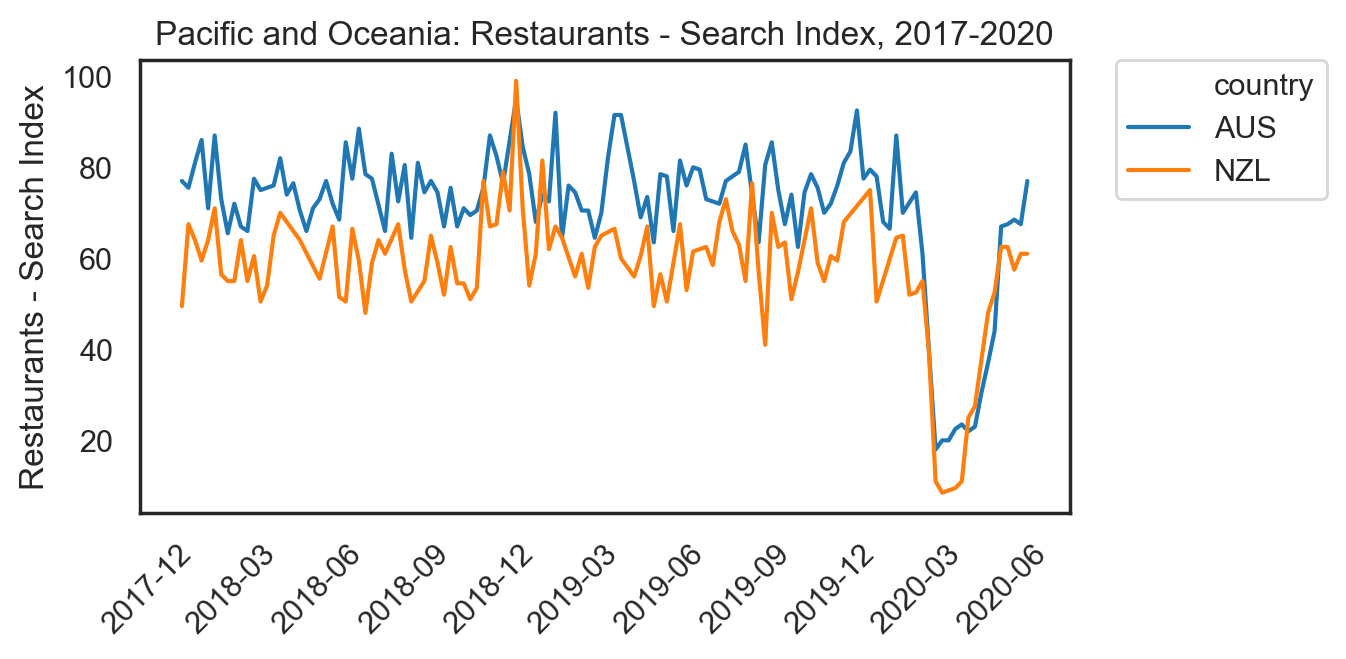

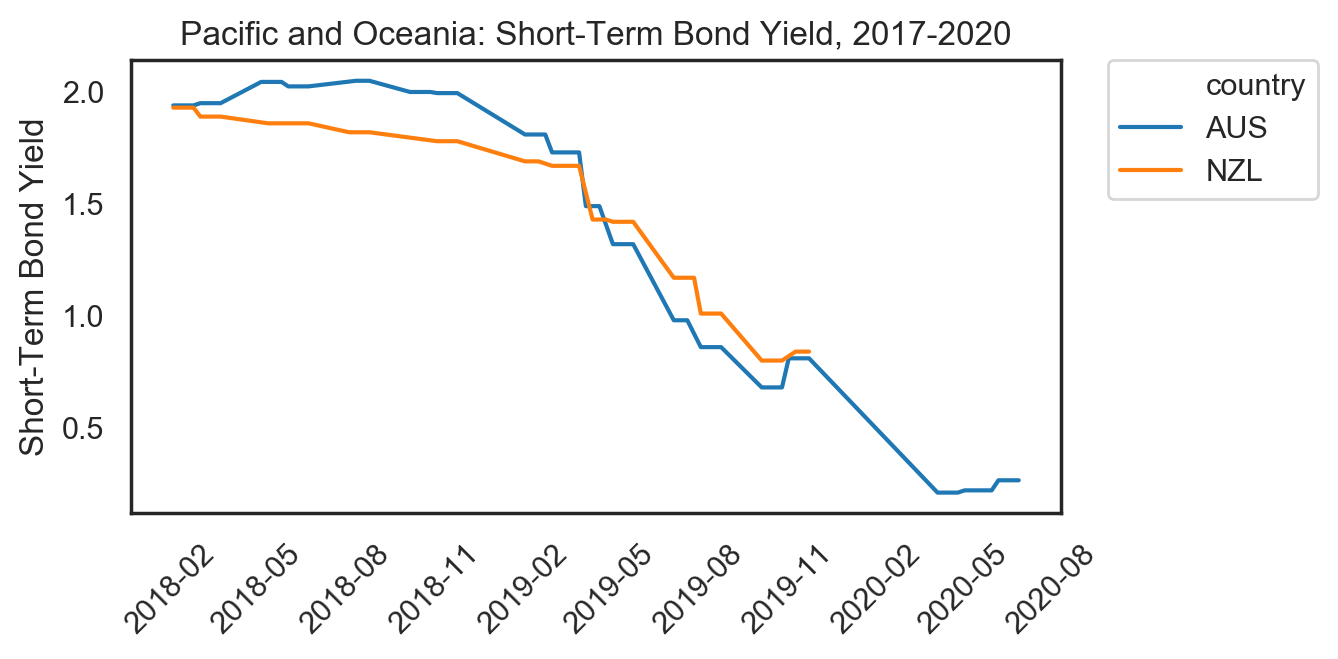

In [229]:
region = pac
reg_str = "Pacific and Oceania"
plot_vars(region, reg_str)

In [ ]:
region = asean4
reg_str = "ASEAN-4"

for var, label in var_dict.items():

    fig, ax = plt.subplots(2, 4, figsize=fig_dims, dpi=dpi)
    data = df[df.country.isin(region)]
    palette = dict(zip(data.country.unique(), sns.color_palette('tab10')))
    sns.lineplot(data=data,
                 y=var,
                 x=data.index,
                 hue='country',
                 legend='brief',
                 palette=palette)
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel(label)
    plt.xlabel('')

    ax.set_title(reg_str + ': ' + label + ', 2017-2020')

# Time Series Analysis

## Stationarity Checks

Here, we perform basic tests on the forecasted variable, PMI. We perform graphical analysis on the rolling mean and rolling standard deviation to confirm these visually. Moreover, we use unit root tests such as the Augmented Dickey-Fuller and Kwiatkowski–Phillips–Schmidt–Shin (KPSS). 

### ASEAN - 4

For all ASEAN-4 countries, we see that all have the existence of a unit root - apart from the Philippines. 

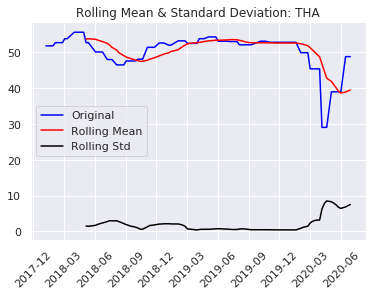

Results of Dickey-Fuller Test:
Test Statistic                 -1.952733
p-value                         0.307674
#Lags Used                      9.000000
Number of Observations Used    80.000000
Critical Value (1%)            -3.514869
Critical Value (5%)            -2.898409
Critical Value (10%)           -2.586439
dtype: float64
Results of KPSS Test:
Test Statistic            0.127265
p-value                   0.084694
Lags Used                12.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


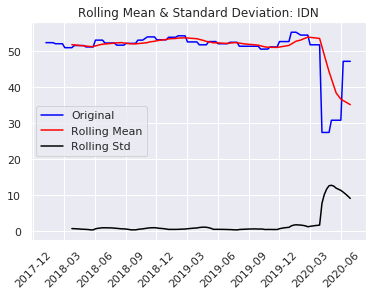

Results of Dickey-Fuller Test:
Test Statistic                  -1.870093
p-value                          0.346259
#Lags Used                      12.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64
Results of KPSS Test:
Test Statistic            0.138269
p-value                   0.064316
Lags Used                13.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


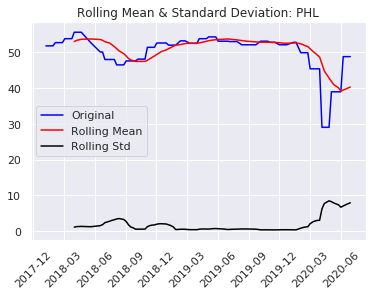

Results of Dickey-Fuller Test:
Test Statistic                 -4.196284
p-value                         0.000669
#Lags Used                      9.000000
Number of Observations Used    92.000000
Critical Value (1%)            -3.503515
Critical Value (5%)            -2.893508
Critical Value (10%)           -2.583824
dtype: float64
Results of KPSS Test:
Test Statistic            0.132837
p-value                   0.074376
Lags Used                13.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


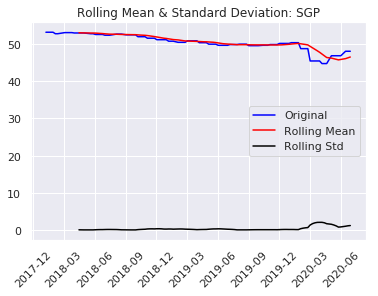

Results of Dickey-Fuller Test:
Test Statistic                   0.134630
p-value                          0.968347
#Lags Used                      12.000000
Number of Observations Used    100.000000
Critical Value (1%)             -3.497501
Critical Value (5%)             -2.890906
Critical Value (10%)            -2.582435
dtype: float64
Results of KPSS Test:
Test Statistic            0.072257
p-value                   0.100000
Lags Used                13.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


In [49]:
countries = ['THA', 'IDN', 'PHL', 'SGP']

for country in countries:
    st_check(df, country, 'pmi')

We take the differenced PMI and run the test once again for Thailand, Indonesia, and Singapore.

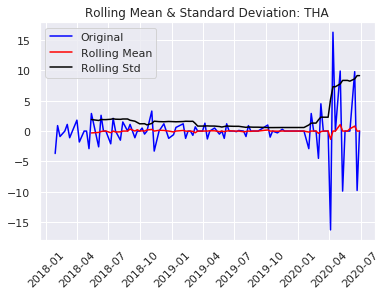

Results of Dickey-Fuller Test:
Test Statistic                 -4.972256
p-value                         0.000025
#Lags Used                      7.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64
Results of KPSS Test:
Test Statistic            0.074692
p-value                   0.100000
Lags Used                12.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


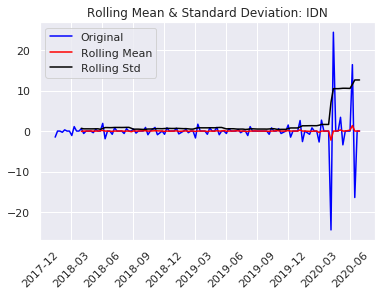

Results of Dickey-Fuller Test:
Test Statistic                  -5.215475
p-value                          0.000008
#Lags Used                      13.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64
Results of KPSS Test:
Test Statistic            0.058464
p-value                   0.100000
Lags Used                13.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


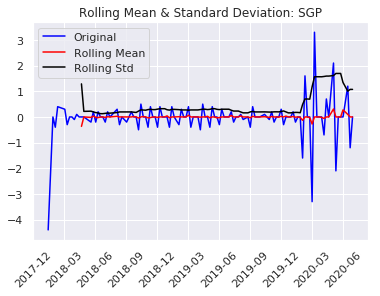

Results of Dickey-Fuller Test:
Test Statistic                  -4.970003
p-value                          0.000025
#Lags Used                      10.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64
Results of KPSS Test:
Test Statistic            0.125968
p-value                   0.087097
Lags Used                13.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


In [50]:
countries = ['THA', 'IDN', 'SGP']

for country in countries:
    st_check(df, country, 'pmi_df', diff=True)

# Time Series Modeling

## Baseline ARIMA

### ASEAN - 4

We now determine the optimal number of lags. First, we use graphical methods such as the ACF and PACF. 

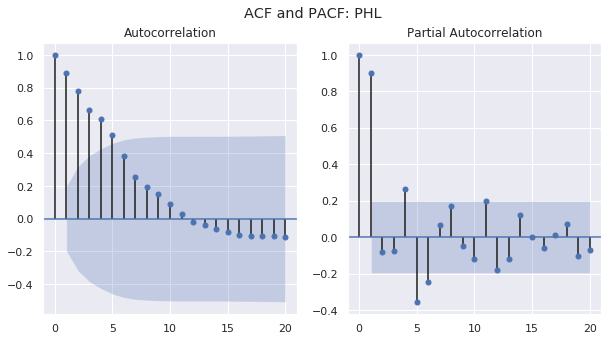

In [77]:
tr_start,tr_end = '2018-01-07','2020-05-31'
te_start,te_end = '2020-06-07','2020-06-28'

plot_corr(df, 'PHL', tr_start, tr_end, te_start, te_end)

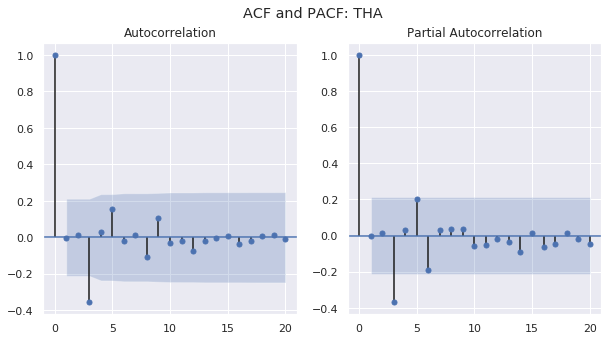

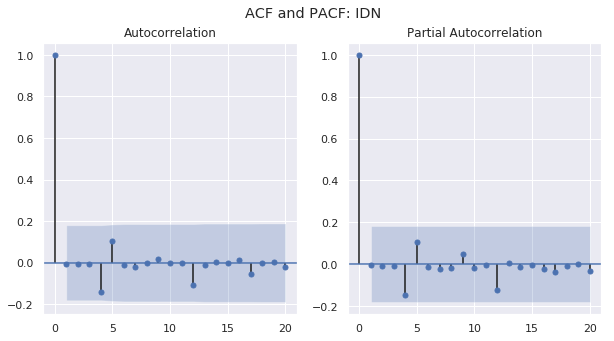

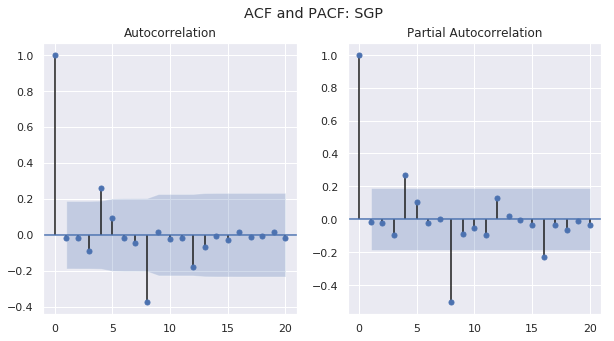

In [78]:
countries = ['THA', 'IDN', 'SGP']

for country in countries:
    plot_corr(df, country, tr_start, tr_end, te_start, te_end, diff=True)

We select the best ARMA(p,q) order based on the AIC and BIC. 

In [82]:
countries = ['THA', 'IDN', 'PHL', 'SGP']

for country in countries:
    resDiff = sm.tsa.arma_order_select_ic(df[df.country==country]['pmi'], max_ar=5, max_ma=5, ic='aic', trend='c')
    print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best for country {}'.format(country))

ARMA(p,q) = (5, 5) is the best for country THA
ARMA(p,q) = (4, 5) is the best for country IDN
ARMA(p,q) = (5, 5) is the best for country PHL
ARMA(p,q) = (1, 4) is the best for country SGP


We now fit the baseline ARIMA models for each country based on the best lag order as determined in the previous step. As seen in the 10-step ahead forecasts, ARIMA does not have a good fit. This is expected given the external shocks from the recent pandemic.

#### Thailand

                           Statespace Model Results                           
Dep. Variable:                    pmi   No. Observations:                   87
Model:               SARIMAX(5, 1, 5)   Log Likelihood                -169.570
Date:                Mon, 20 Jul 2020   AIC                            361.140
Time:                        12:10:44   BIC                            387.343
Sample:                             0   HQIC                           371.646
                                 - 87                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4640      1.676     -0.874      0.382      -4.748       1.821
ar.L2         -1.0178      2.761     -0.369      0.712      -6.430       4.394
ar.L3         -1.2385      2.162     -0.573      0.5

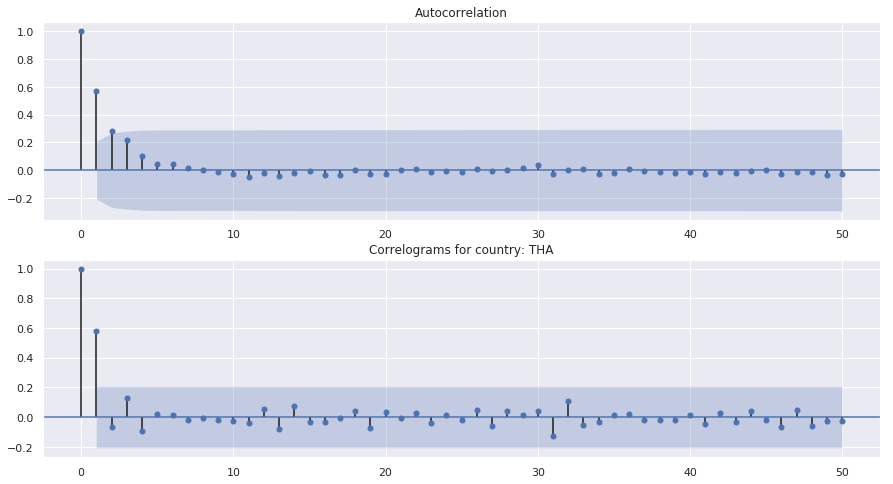

ARIMA model MSE for 10-step ahead forecast:68.2418948035091


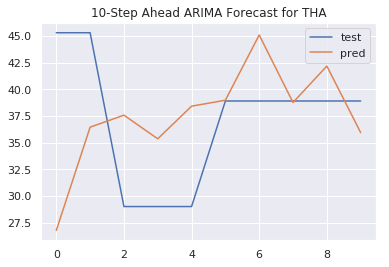

In [228]:
fit_arima('THA', tr_start, tr_end, te_start, te_end, order = (5,1,5))

#### Indonesia

                           Statespace Model Results                           
Dep. Variable:                    pmi   No. Observations:                  119
Model:               SARIMAX(4, 1, 5)   Log Likelihood                -254.533
Date:                Mon, 20 Jul 2020   AIC                            529.067
Time:                        12:11:17   BIC                            556.252
Sample:                             0   HQIC                           540.097
                                - 119                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6406     17.104     -0.037      0.970     -34.163      32.882
ar.L2         -0.5038     15.182     -0.033      0.974     -30.260      29.252
ar.L3         -0.4914     14.765     -0.033      0.9

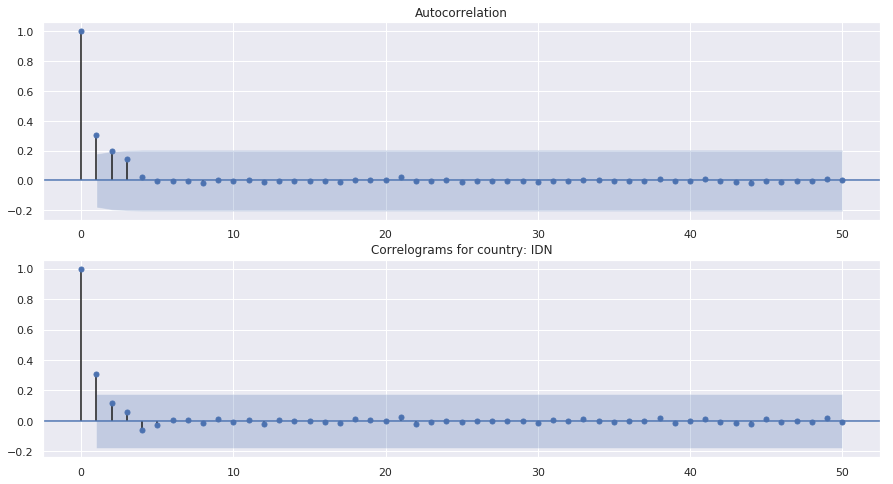

ARIMA model MSE for 10-step ahead forecast:390.00975548459485


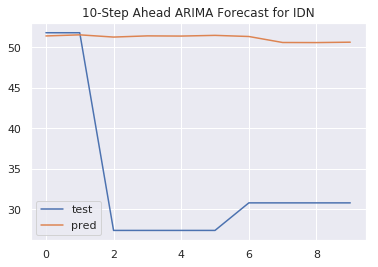

In [229]:
fit_arima('IDN', tr_start, tr_end, te_start, te_end, order = (4,1,5))

#### Philippines

                           Statespace Model Results                           
Dep. Variable:                    pmi   No. Observations:                   98
Model:               SARIMAX(5, 0, 5)   Log Likelihood                -188.784
Date:                Mon, 20 Jul 2020   AIC                            399.568
Time:                        12:11:35   BIC                            427.308
Sample:                             0   HQIC                           410.764
                                 - 98                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4576      0.231     -1.981      0.048      -0.910      -0.005
ar.L2          0.2088      0.198      1.052      0.293      -0.180       0.598
ar.L3          0.2561      0.199      1.288      0.1

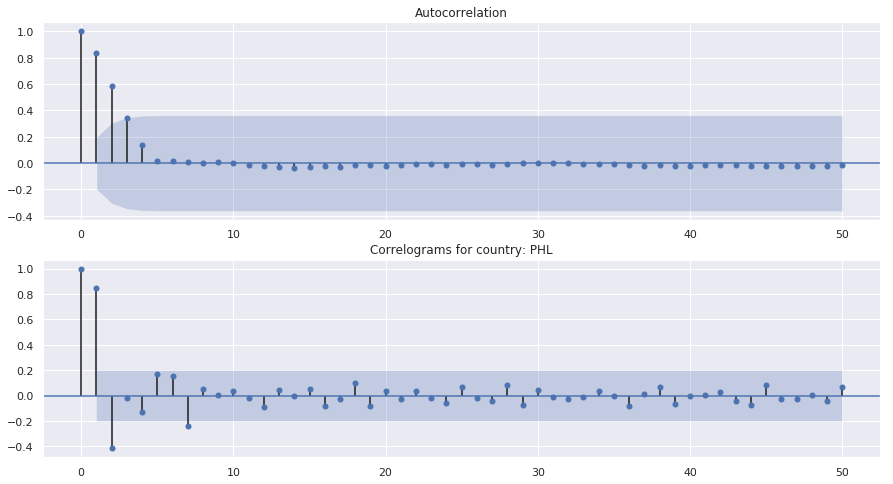

ARIMA model MSE for 10-step ahead forecast:164.77040831387106


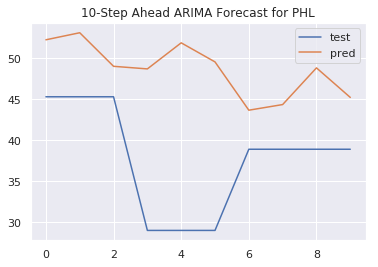

In [230]:
fit_arima('PHL', tr_start, tr_end, te_start, te_end, order = (5,0,5))

#### Singapore

                           Statespace Model Results                           
Dep. Variable:                    pmi   No. Observations:                  110
Model:               SARIMAX(1, 1, 4)   Log Likelihood                 -46.892
Date:                Mon, 20 Jul 2020   AIC                            105.784
Time:                        12:11:45   BIC                            121.650
Sample:                             0   HQIC                           112.212
                                - 110                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0208      0.186     -0.112      0.911      -0.385       0.343
ma.L1         -0.0546      0.145     -0.376      0.707      -0.339       0.230
ma.L2          0.0238      0.193      0.123      0.9

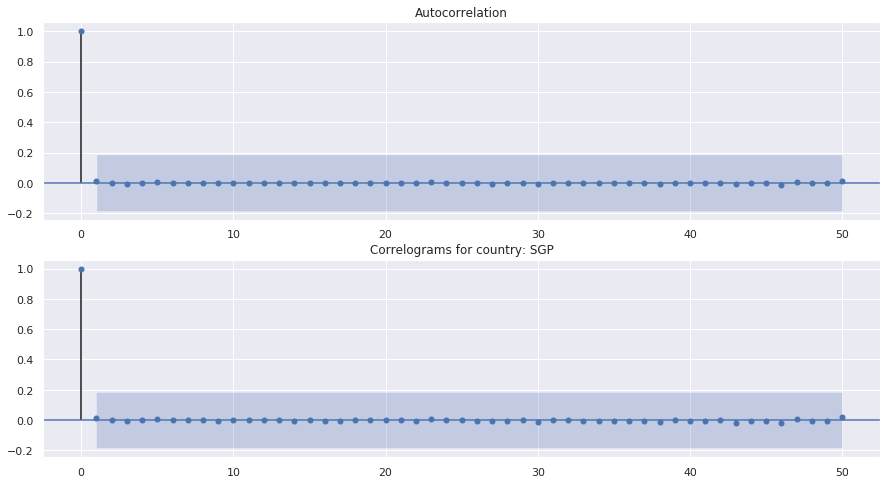

ARIMA model MSE for 10-step ahead forecast:17.899997374869653


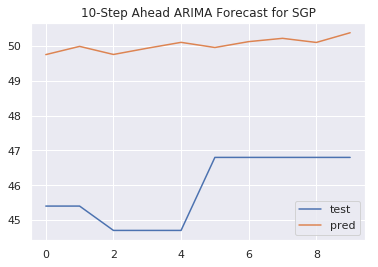

In [231]:
fit_arima('SGP', tr_start, tr_end, te_start, te_end, order = (1,1,4))